## Wasppa 21 metrics
### Efthymios Tzinis

In [1]:
import os, sys 
import torch 
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import IPython.display as ipd
from argparse import Namespace
import torch.nn as nn 
import torch.nn.functional as F
import librosa
import argparse
import scipy 
from IPython.display import Audio
import numpy as np
from matplotlib.pyplot import cm
from tqdm import tqdm
import time
import comet_ml
from pprint import pprint
import pandas as pd

sys.path.append("../")
from __config__ import *
# plt.style.use('science')
# plt.style.use(['science','ieee','no-latex'])
plt.style.reload_library()
plt.style.use(['science', 'ieee'])

In [2]:
project_api = comet_ml.API(api_key=API_KEY)
exp_name = 'waspaa21-fedenhance'
username_comet = 'etzinis'
exp_dict = {'fedenhance': {'exp_name': exp_name}}

In [3]:
# Gather all appropriate data from the comet_ml experiments
val_metric_names = [
    'validate_SISDRi_enhancement_1_noises_mean',
    'validate_test_SISDRi_enhancement_1_noises_mean',
    'validate_SISDRi_enhancement_2_noises_mean',
    'validate_test_SISDRi_enhancement_2_noises_mean',
]
results_dict = dict([(dataset, {}) for dataset in exp_dict.keys()])

for dataset in exp_dict.keys():
    this_experiments = project_api.get(username_comet, exp_dict[dataset]['exp_name'])
    for comet_exp in this_experiments:
        comet_id = comet_exp.id
        exp_data = project_api.get(username_comet, exp_dict[dataset]['exp_name'], comet_id)
        this_name = exp_data.name
        this_id = exp_data.id
        this_small_id = exp_data.id[:4]
        if this_name in results_dict[dataset]:
            print('Overriding experiment: {} with {}'.format(this_name, this_id))
        results_dict[dataset][this_name] = {'actual_id': this_id, 'name': this_name, 'small_id': this_small_id}
        for val_metric_name in val_metric_names:
            this_val_metric = exp_data.get_metrics(val_metric_name)
            metric_list = [float(x['metricValue']) for x in this_val_metric]
            results_dict[dataset][this_name][val_metric_name] = np.array(metric_list)

In [4]:
results_dict['fedenhance'].keys()

dict_keys(['indiv_nodes_256', 'indiv_nodes_64', 'indiv_nodes_16', 'multi_nodes_64_p_avail_0.25_lcl_ep_25_p_sup_0_pat_0', 'multi_nodes_64_p_avail_0.25_lcl_ep_5_p_sup_0_pat_0', 'multi_nodes_16_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0', 'multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0', 'multi_nodes_64_p_avail_0.125_lcl_ep_1_p_sup_0_pat_0', 'multi_nodes_64_p_avail_1_lcl_ep_1_p_sup_0_pat_0', 'pretrain_3losses_p_sup_1_p_single_0.5_std', 'pretrain_1loss_p_sup_1_p_single_0._std', 'pretrain_3losses_p_sup_1_p_single_0.0_std', 'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0', 'multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0.5_pat_0', 'multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0.25_pat_0', 'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0.25_pat_0', 'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0.5_pat_0', 'pretrained_nodes_64_p_avail_0.25_lcl_ep_1_lre-5_p_sup_0_pat_0', 'pretrained_nodes_256_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0', 'pretrained_nodes_64_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0', 

$ \textsc{FedEnhance}$ $C=256$ (1009,)
$ \textsc{FedEnhance}$ $C=64$ (1015,)
$ \textsc{FedEnhance}$ $C=16$ (1032,)
$ \textsc{FedEnhance}$ $C=256$ (1009,)
$ \textsc{FedEnhance}$ $C=64$ (1015,)
$ \textsc{FedEnhance}$ $C=16$ (1032,)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


$ \textsc{FedEnhance}$ $C=256$ (1009,)
$ \textsc{FedEnhance}$ $C=64$ (1015,)
$ \textsc{FedEnhance}$ $C=16$ (1032,)
$ \textsc{FedEnhance}$ $C=256$ (1009,)
$ \textsc{FedEnhance}$ $C=64$ (1015,)
$ \textsc{FedEnhance}$ $C=16$ (1032,)


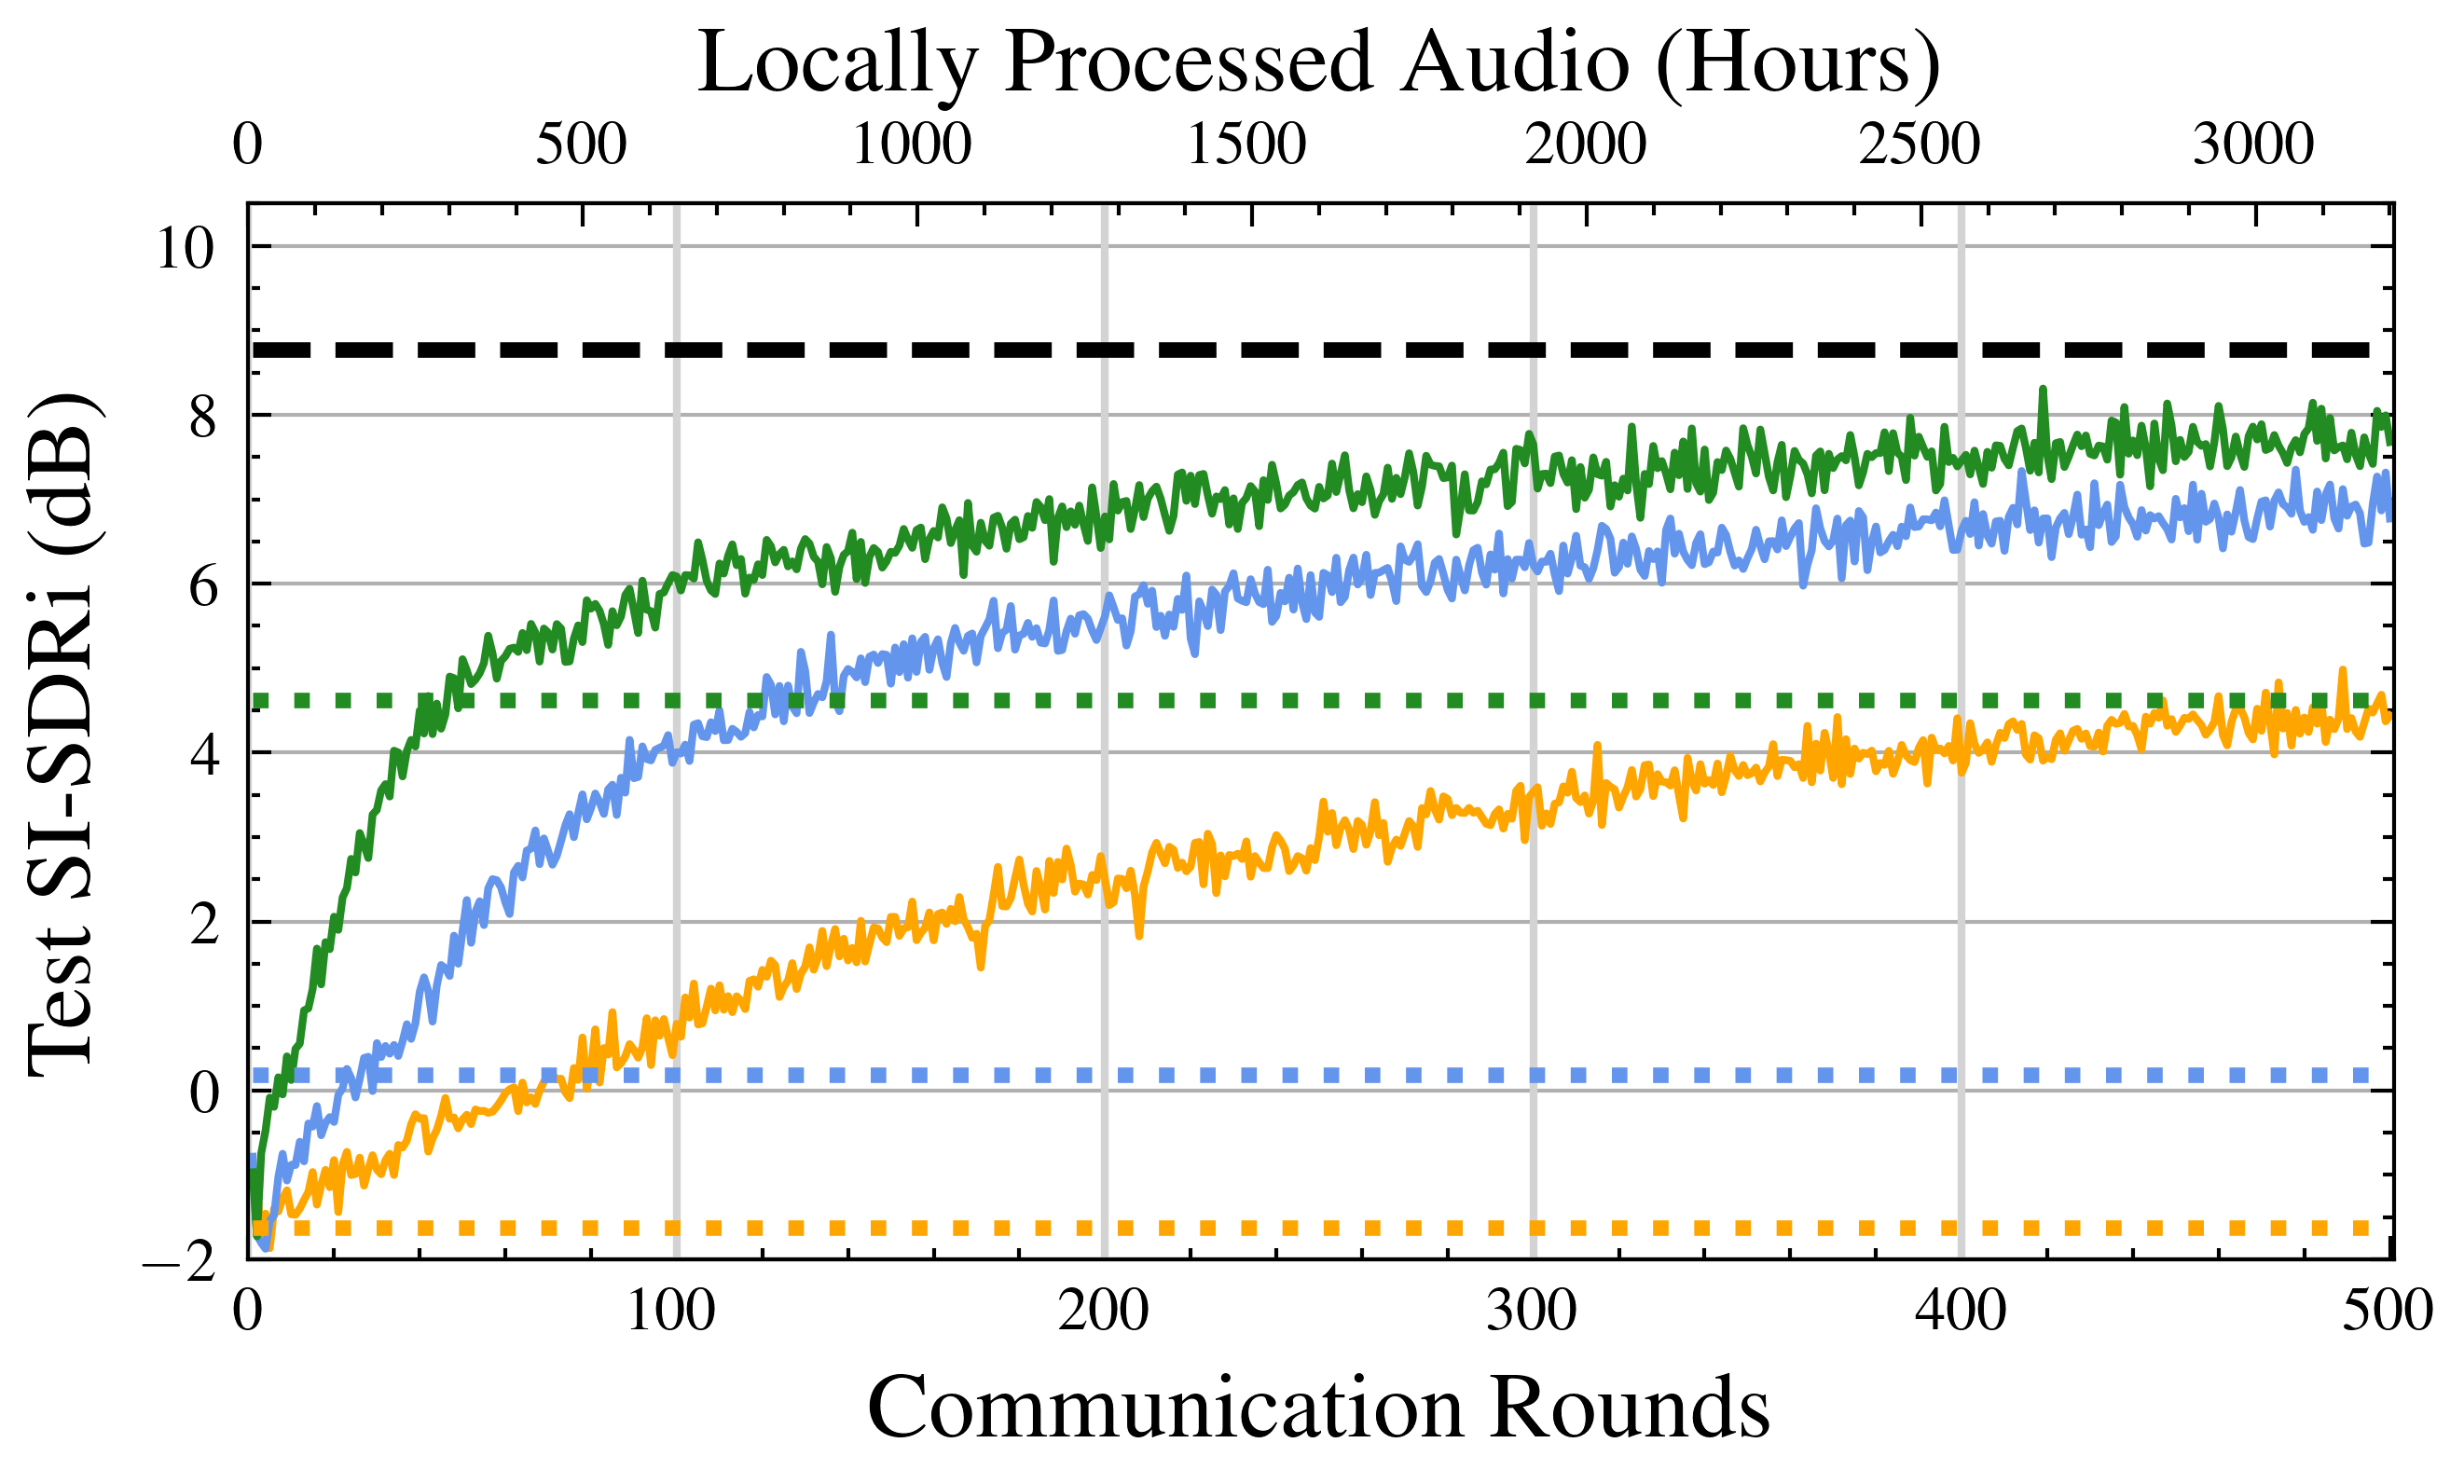

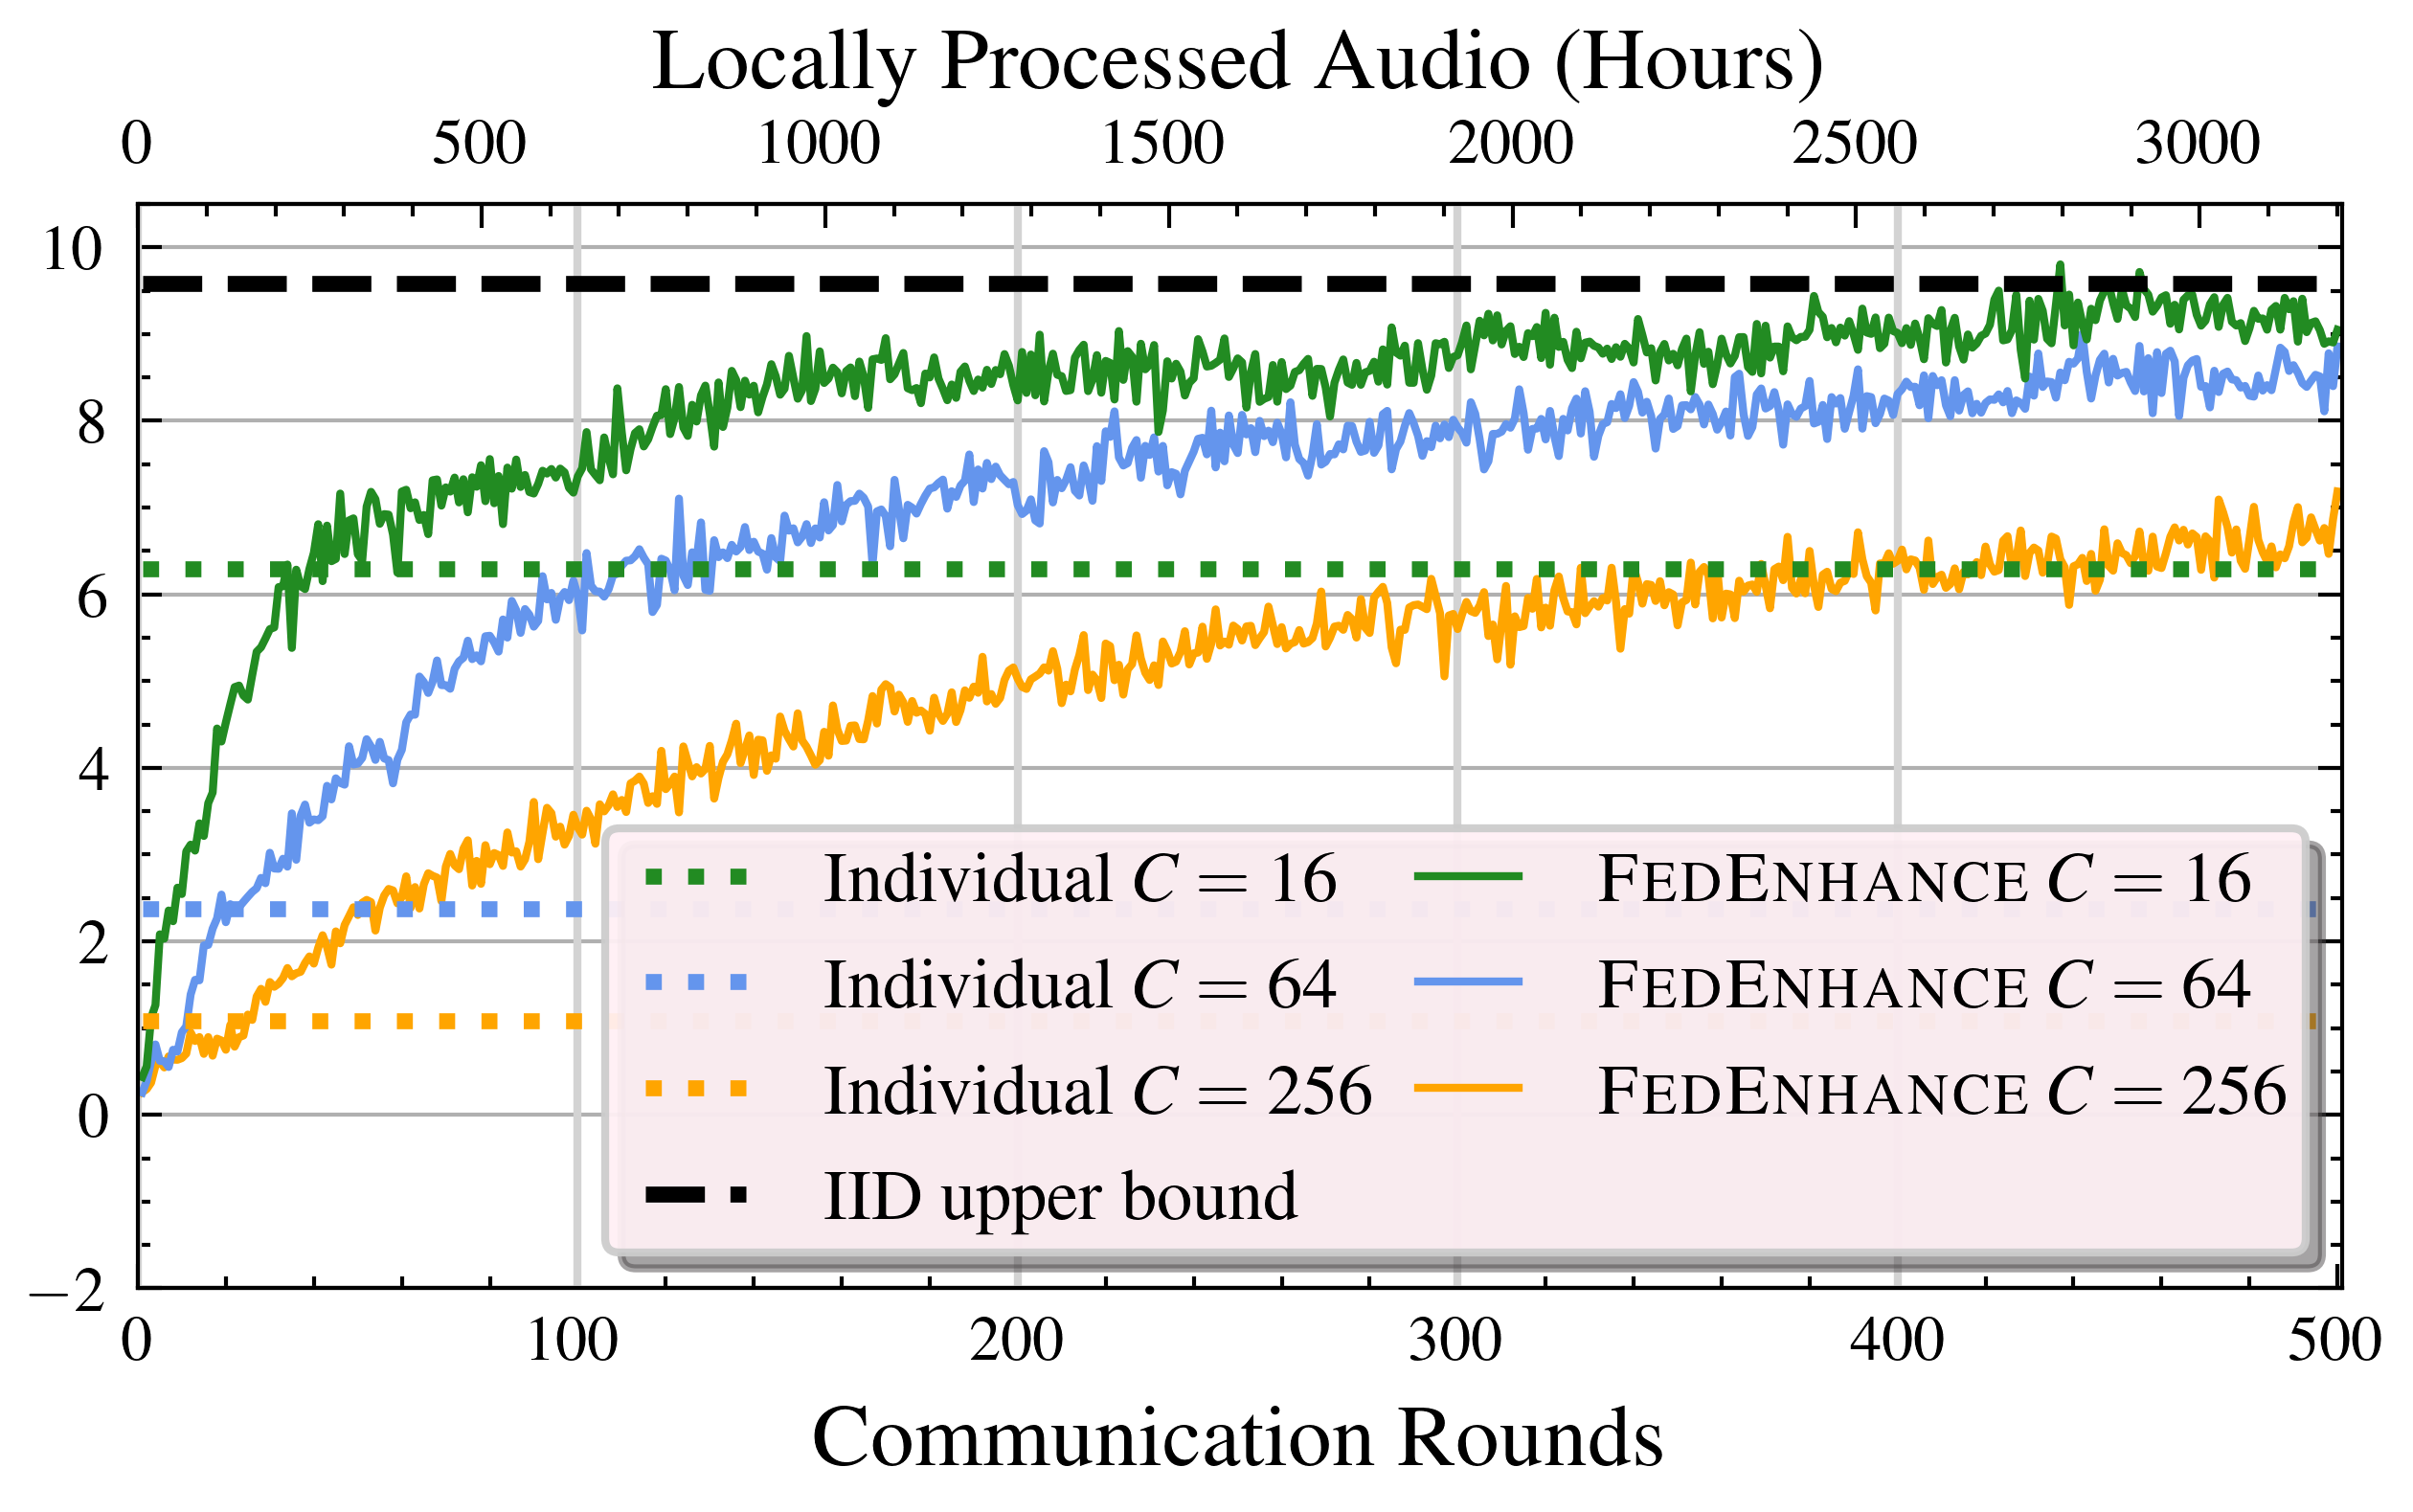

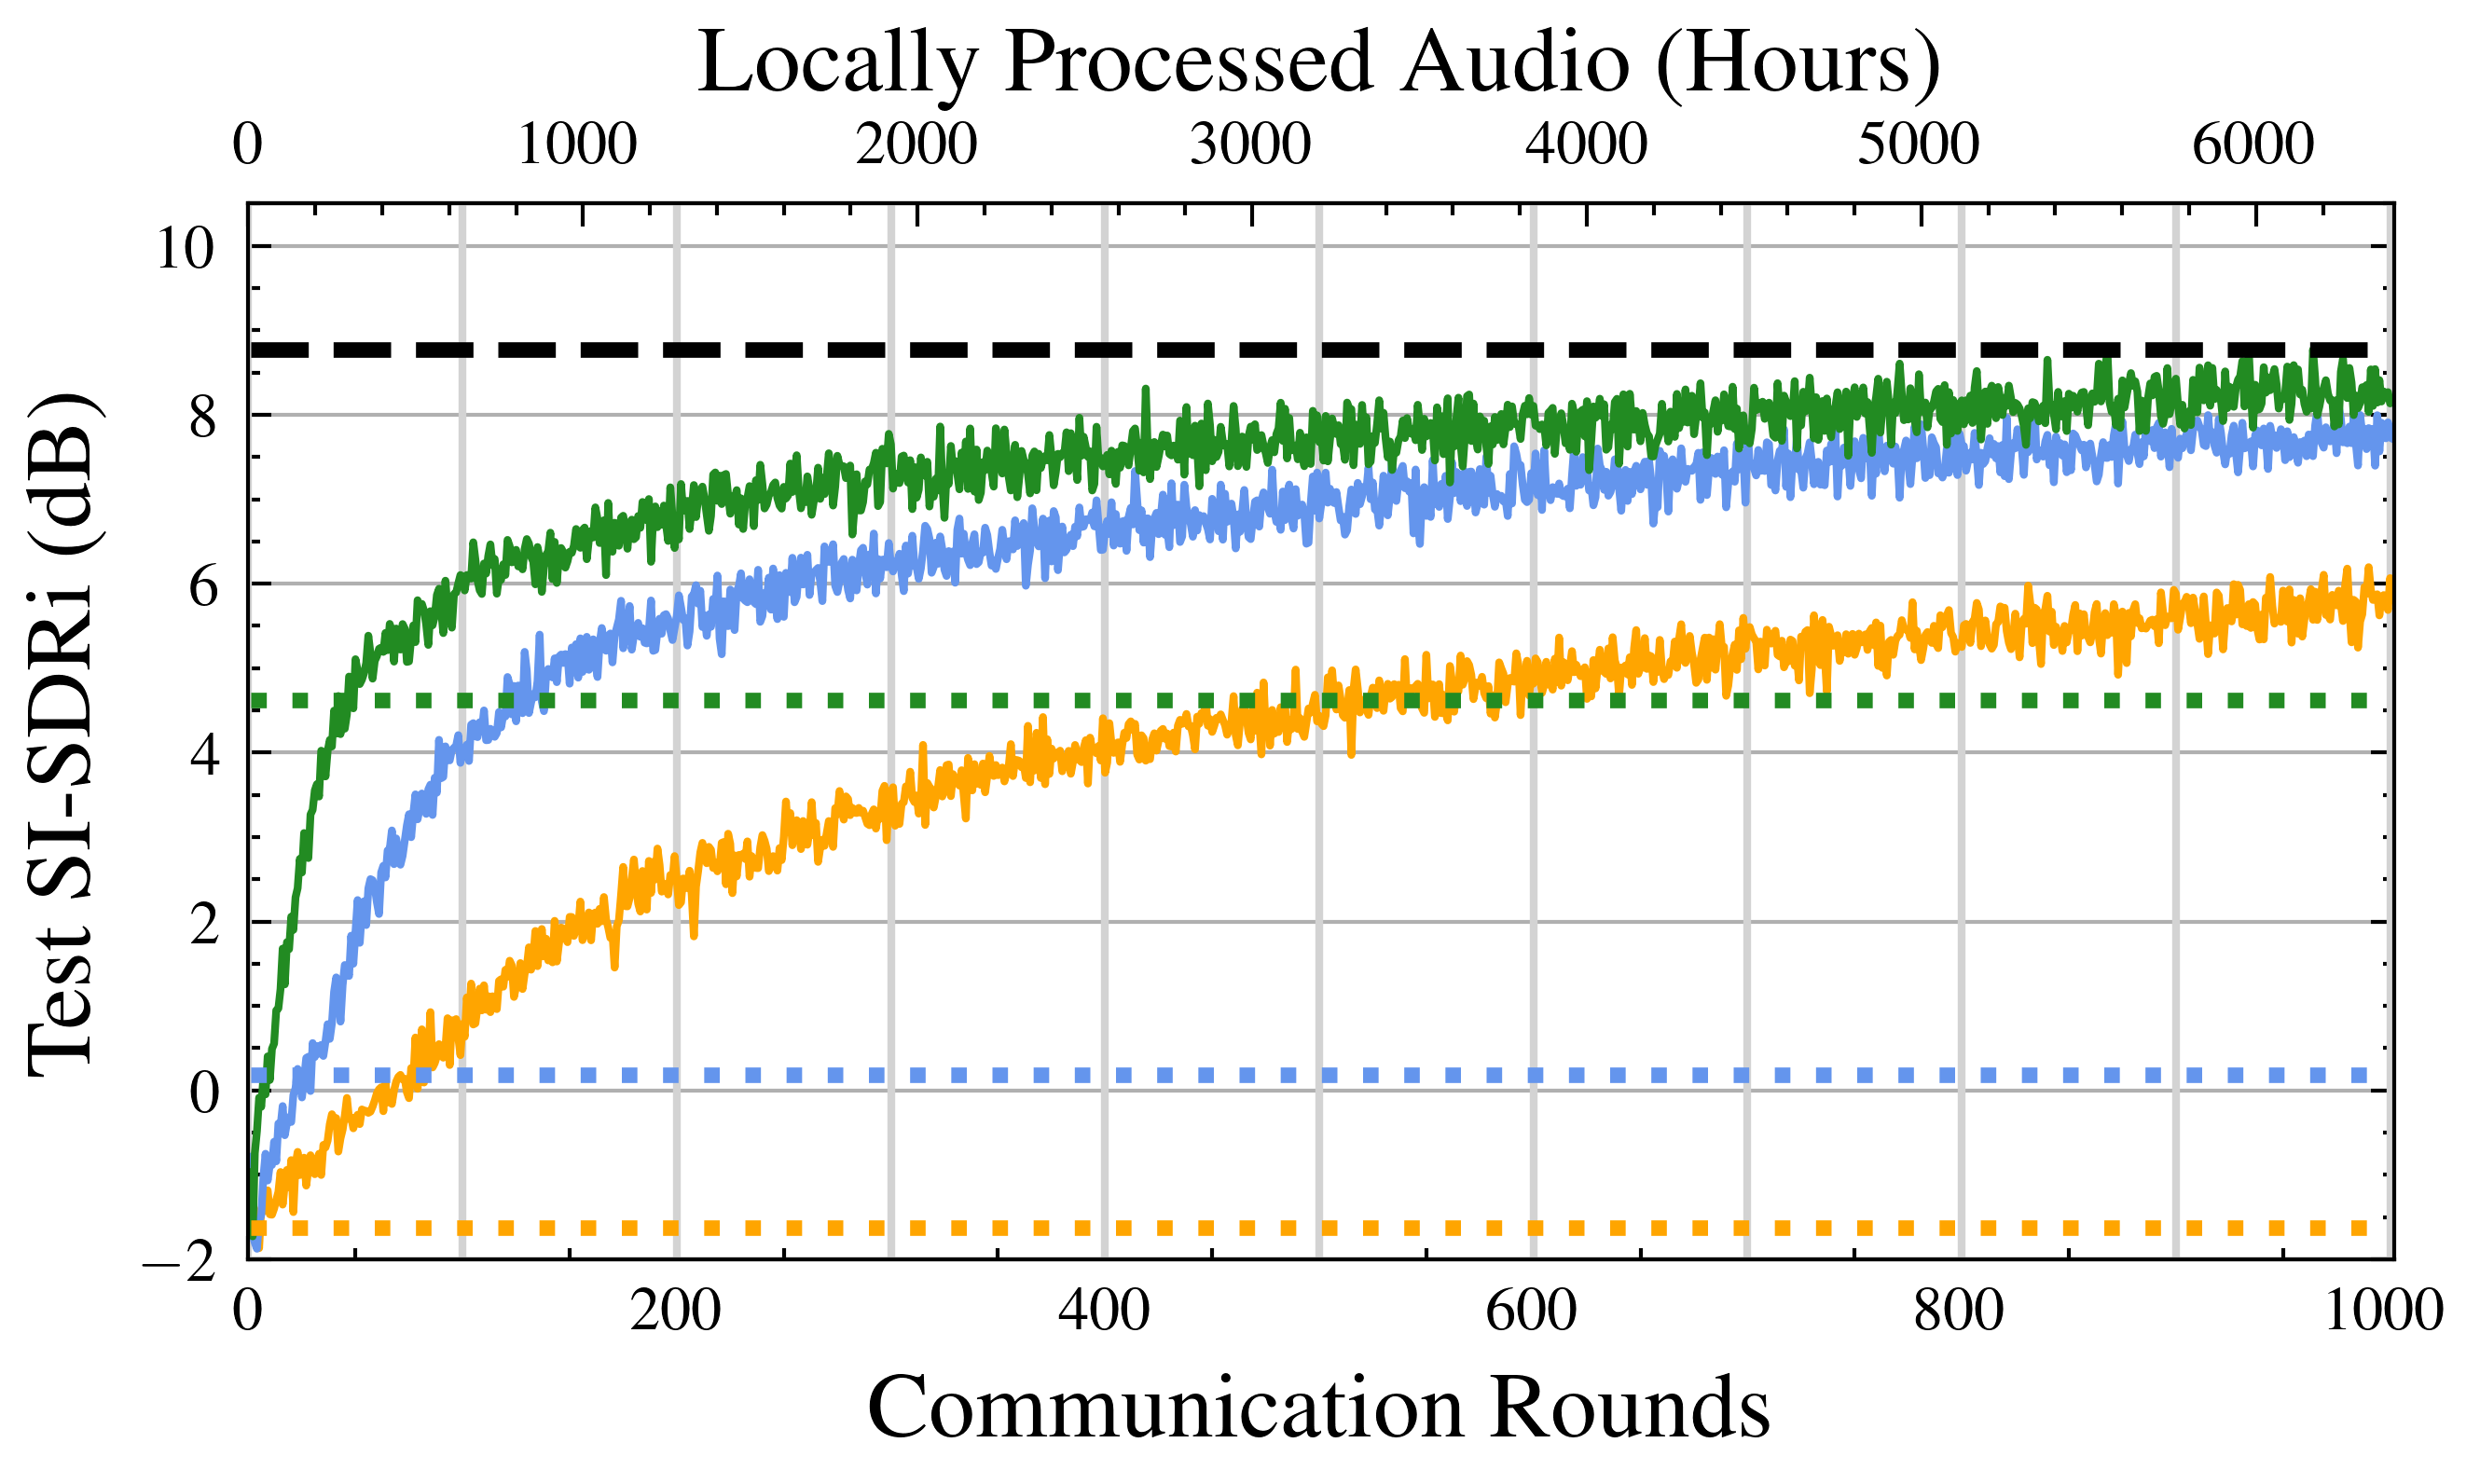

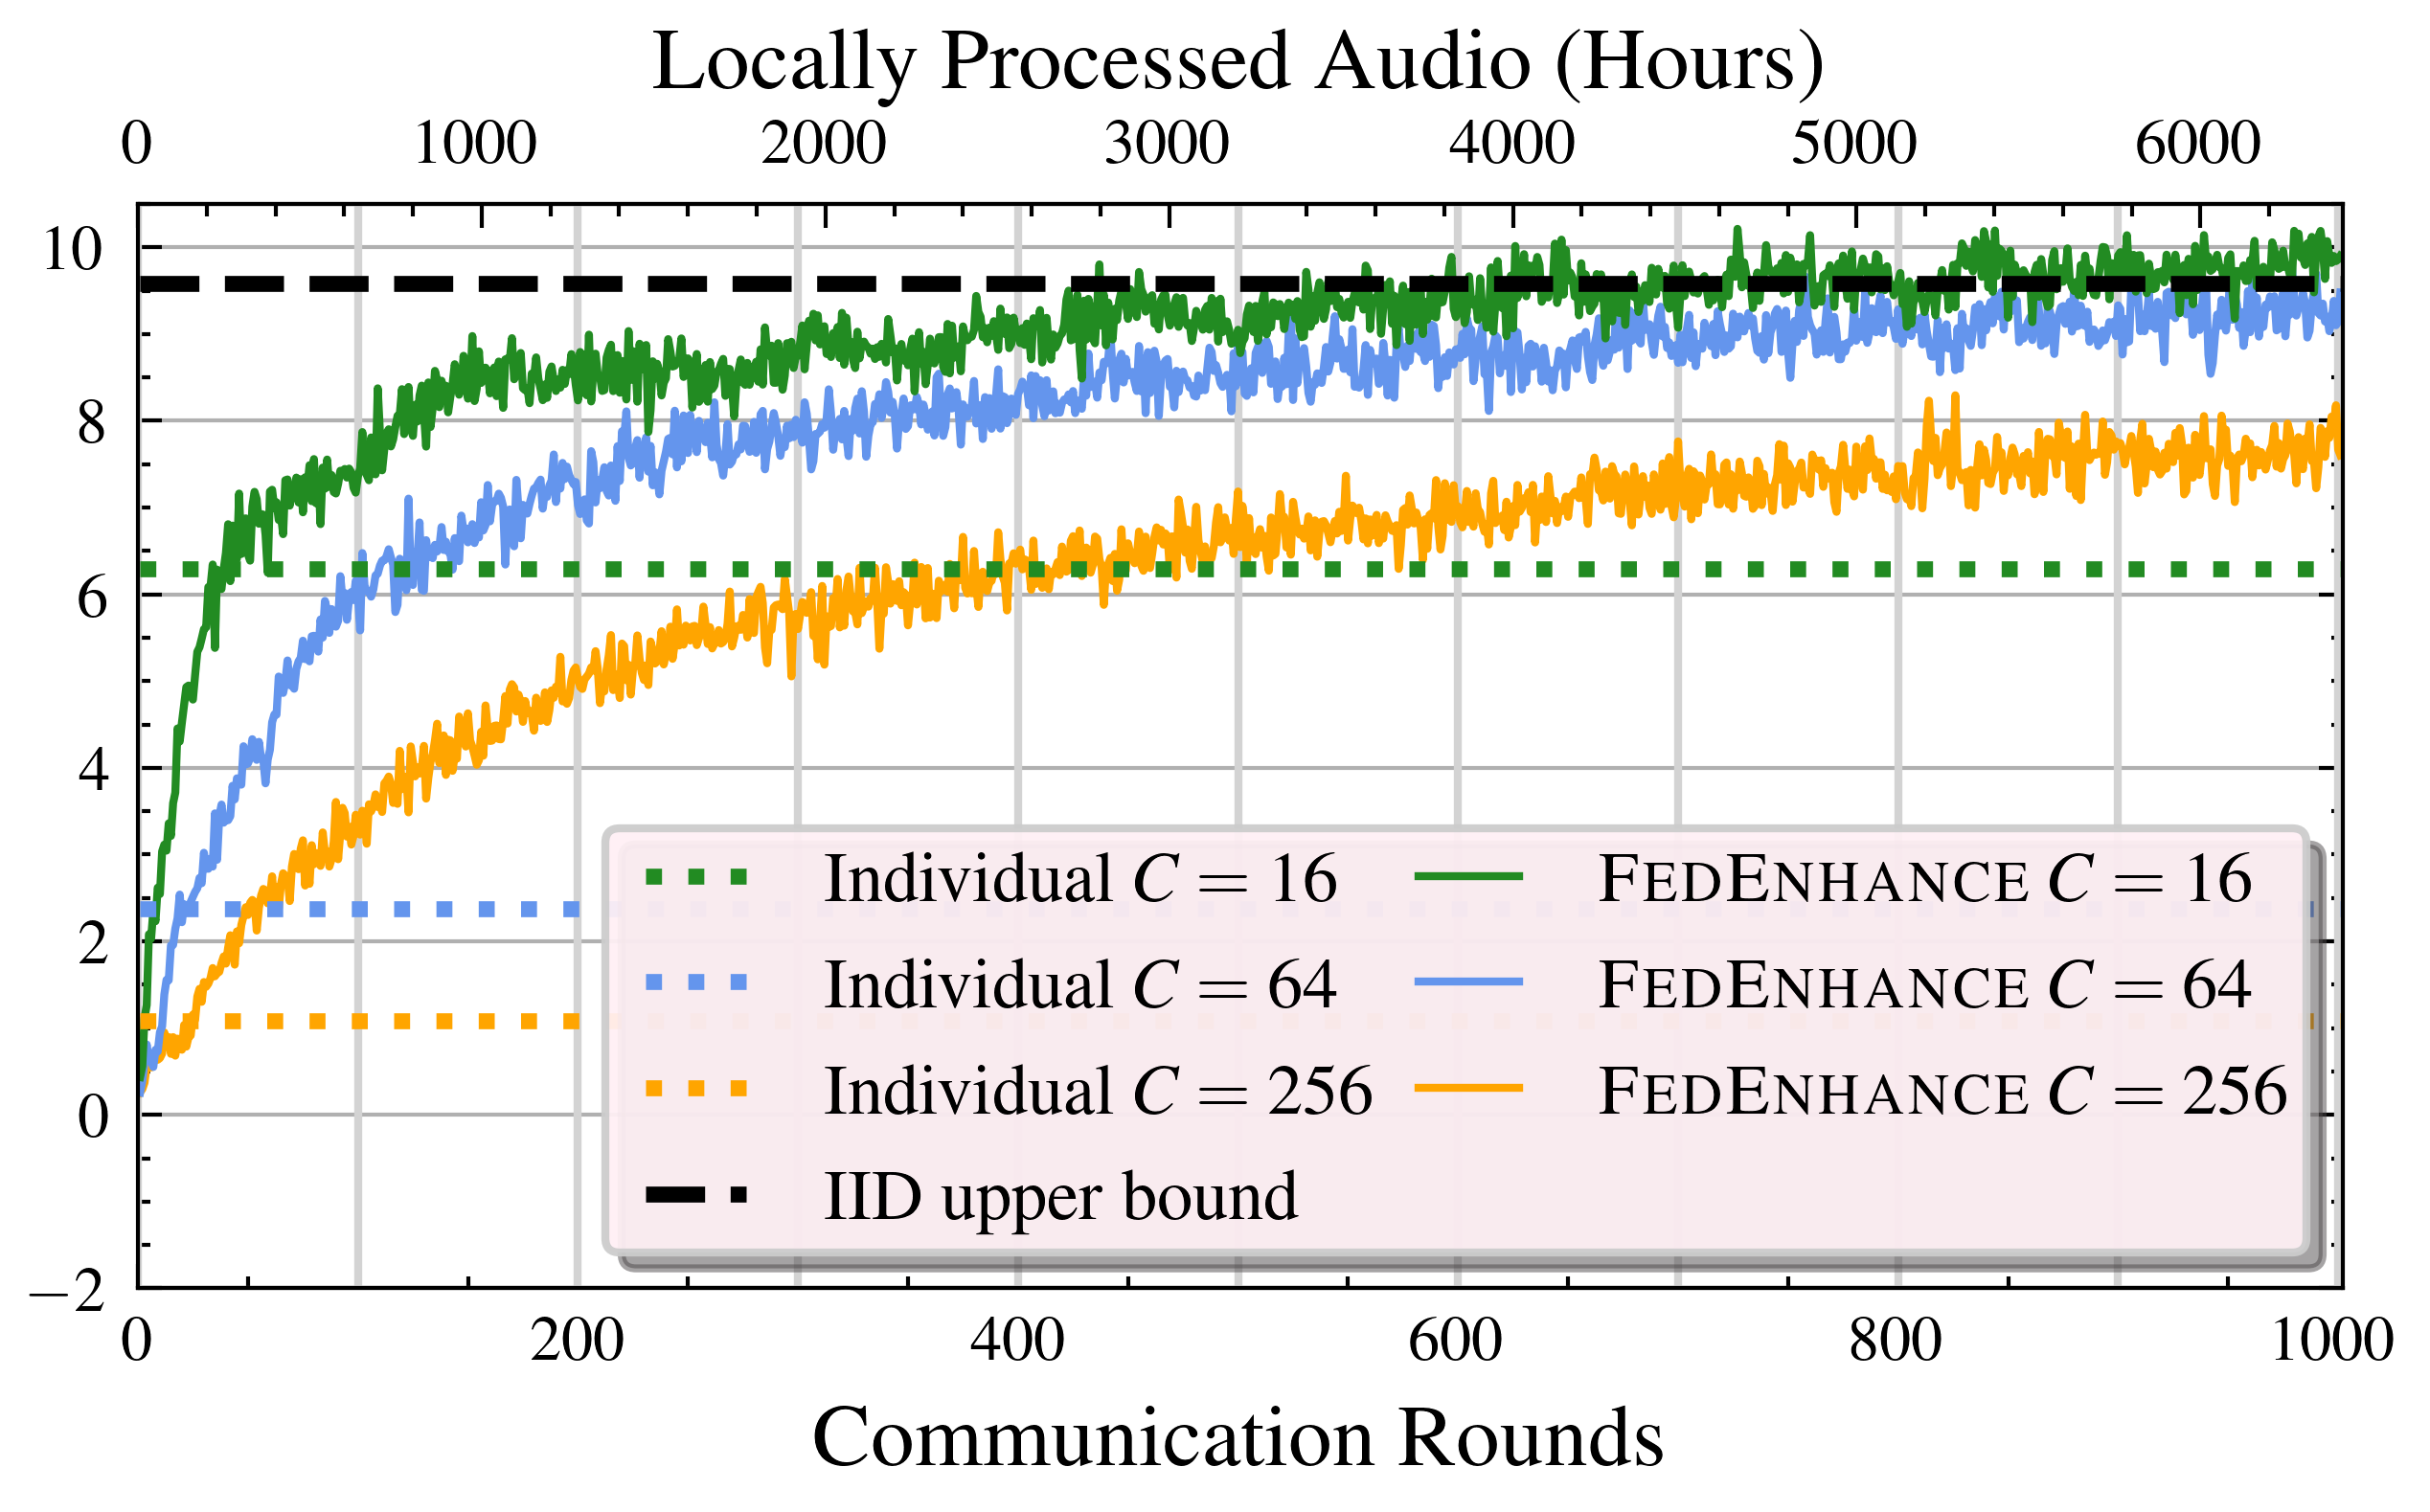

In [5]:
# Plot convergence for FL setups
# Gather all results which are needed
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preview'] = True



def get_figure_dics_for_num_noise(num_noises):
    metric_name = f'validate_test_SISDRi_enhancement_{num_noises}_noises_mean'
    test_metric_name = metric_name
    val_metric_name = f'validate_SISDRi_enhancement_{num_noises}_noises_mean'
    rename_map = {
        'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': '$ \\textsc{FedEnhance}$ $C=256$',
        'dnn_multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': '$ \\textsc{FedEnhance}$ $C=64$',
        'dnn_multi_nodes_16_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': '$ \\textsc{FedEnhance}$ $C=16$',
        'indiv_nodes_256': 'Individual $C=256$',
        'indiv_nodes_64': 'Individual $C=64$',
        'indiv_nodes_16': 'Individual $C=16$',
        'scratch_single_node_unsup_fedunsup': 'IID upper bound'
    }
    
    color_list = ['darkorange', 'royalblue', 'forestgreen',
                  'peachpuff', 'lightskyblue', 'lightgreen',
                  'black']
    
    color_list = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

    color_list = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                  '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'][::-1]

    
    color_list = ['orange', 'cornflowerblue', 'forestgreen',
                  'orange', 'cornflowerblue', 'forestgreen',
                  'black']
    
    figure_dic = {
        '$ \\textsc{FedEnhance}$ $C=256$': {'color': color_list[0], 'linestyle': '-', 'marker': 'o'},
        '$ \\textsc{FedEnhance}$ $C=64$': {'color': color_list[1], 'linestyle': '-', 'marker': 'p'},
        '$ \\textsc{FedEnhance}$ $C=16$': {'color': color_list[2], 'linestyle': '-', 'marker': 's'},
        'Individual $C=256$': {'color': color_list[3], 'linestyle': 'dotted', 'marker': '*'},
        'Individual $C=64$': {'color': color_list[4], 'linestyle': 'dotted', 'marker': '*'},
        'Individual $C=16$': {'color': color_list[5], 'linestyle': 'dotted', 'marker': '*'},
        'IID upper bound': {'color': color_list[6], 'linestyle': '--', 'marker': '*'},
    }

    straight_lines_names = [
        'indiv_nodes_256', 'indiv_nodes_64', 'indiv_nodes_16', 'scratch_single_node_unsup_fedunsup'
    ]
    straight_lines_dic = dict([(rename_map[x], results_dict['fedenhance'][x])
                               for x in straight_lines_names])

    converging_lines_names = [
        'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0',
        'dnn_multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0',
        'dnn_multi_nodes_16_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0'
    ]
    converging_lines_dic = dict([(rename_map[x], results_dict['fedenhance'][x])
                                 for x in converging_lines_names])
    return converging_lines_dic, straight_lines_dic, figure_dic, test_metric_name, val_metric_name


def plot_convergence(straight_lines_dic, converging_lines_dic,
                     test_metric_name, val_metric_name, figure_dic, filename,
                     ylabel = 'Test SI-SDRi (dB)', xlabel_down='Communication Rounds',
                     xlabel_top = 'Locally Processed Audio (Hours)',
                     max_epochs=500, axis_fontsize=13, legend_fontsize=8, use_legend=False):
#     fig = plt.gcf()
    fig, ax = plt.subplots(constrained_layout=True)
#     fig.set_size_inches(18.25, 7)
    xs = np.arange(1, max_epochs+1)
    for j in range(0, max_epochs, 100):
        ax.axvline(j, linestyle='-', linewidth=1, color='lightgray') # vertical lines
    
    for name, data in converging_lines_dic.items():
        ys = data[test_metric_name][:max_epochs]
        print(name, data[test_metric_name].shape)
        ax.plot(xs, ys,
                 color=figure_dic[name]['color'],
                 linestyle=figure_dic[name]['linestyle'],
#                  marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 label=name,
                 linewidth=1,
                 markersize=1)
    
    for name, data in straight_lines_dic.items():
        val_ys = data[val_metric_name]
        best_index = np.argmax(val_ys)
        test_ys = data[test_metric_name]
        best_test_value = test_ys[best_index]
        # Repeat the best value across x         
        ys = np.repeat(best_test_value, max_epochs)
        ax.plot(xs, ys,
                 color=figure_dic[name]['color'],
                 linestyle=figure_dic[name]['linestyle'],
#                  marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 label=name,
                 linewidth=2,
                 markersize=1)
    if not use_legend:
        ax.set_ylabel(ylabel, fontsize=axis_fontsize)
#     ax.set_xlabel(xlabel_down, fontsize=axis_fontsize)
    ax.set_xticks([])
#     ax.spines['top'].set_visible(False)
#     ax.set_xticks(np.arange(1, max_epochs+1, 100))
    
    # Add secondary axis with audio processed per communication round
    def hours2rounds(h):
        clips_secs = 4
        total_training_mixtures = 0.5 * 46085 * clips_secs / 3600. 
        return 4 * h / total_training_mixtures
    
    def rounds2hours(x):
        clips_secs = 4
        total_training_mixtures = 0.5 * 46085 * clips_secs / 3600.
        return 0.25 * x * total_training_mixtures
    secax = ax.secondary_xaxis('top', functions=(rounds2hours, hours2rounds))
    secax.set_xlabel(xlabel_top, fontsize=axis_fontsize)
    
    thiax = ax.secondary_xaxis('bottom', functions=(lambda x: x, lambda x: x))
    thiax.set_xlabel(xlabel_down, fontsize=axis_fontsize)
#     ax.xaxis.grid(True, which='major')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.5, box.height])
    
    def reorder_legend(handles, labels):
        handle_dic = dict([(l, h) for (h, l) in zip(handles, labels)])
        return_list = [
            ('Individual $C=16$', handle_dic['Individual $C=16$']),
            ('Individual $C=64$', handle_dic['Individual $C=64$']),
            ('Individual $C=256$', handle_dic['Individual $C=256$']),
            ('IID upper bound', handle_dic['IID upper bound']),
            ('$ \\textsc{FedEnhance}$ $C=16$', handle_dic['$ \\textsc{FedEnhance}$ $C=16$']),
            ('$ \\textsc{FedEnhance}$ $C=64$', handle_dic['$ \\textsc{FedEnhance}$ $C=64$']),
            ('$ \\textsc{FedEnhance}$ $C=256$', handle_dic['$ \\textsc{FedEnhance}$ $C=256$']),
        ]
        return [x[0] for x in return_list], [x[1] for x in return_list]

    plt.ylim([-2, 10.5])
    plt.xlim([0, max_epochs+1])

#     plt.xticks(np.arange(1, max_epochs+1, 50))
    if use_legend:
        handles, labels = ax.get_legend_handles_labels()
        labels, handles = reorder_legend(handles, labels)

    #     ax.set_xticklabels(xlabels, Fontsize= )
        plt.legend(handles, labels, borderpad=0.25, columnspacing=0.3,
                   ncol=2, loc='lower right', fontsize=legend_fontsize, numpoints=2,
                   fancybox=True, shadow=True, framealpha= 0.94, frameon=True, facecolor='lavenderblush',
#                    bbox_to_anchor=(1.5, 0.4)
                  )
#     plt.show()

    plt.grid()
    plt.savefig(f'{filename}.pdf', dpi=100, bbox_inches='tight')

for max_epochs in [500, 1001]:
    num_noises = 1
    filename = f'convergence_scratch_{num_noises}_{max_epochs}'
    (converging_lines_dic, straight_lines_dic,
     figure_dic, test_metric_name, val_metric_name) = get_figure_dics_for_num_noise(num_noises)
    plot_convergence(straight_lines_dic, converging_lines_dic,
                     test_metric_name, val_metric_name, figure_dic, filename, max_epochs=max_epochs,
                     axis_fontsize=12, legend_fontsize=8, use_legend=False)

    num_noises = 2
    filename = f'convergence_scratch_{num_noises}_{max_epochs}'

    (converging_lines_dic, straight_lines_dic,
     figure_dic, test_metric_name, val_metric_name) = get_figure_dics_for_num_noise(num_noises)
    plot_convergence(straight_lines_dic, converging_lines_dic,
                     test_metric_name, val_metric_name, figure_dic, filename, max_epochs=max_epochs,
                     axis_fontsize=11, legend_fontsize=9, use_legend=True)

Random Init. $C=256$ (500,)
Random Init. $C=64$ (500,)
Random Init. $C=16$ (500,)
Pre-trained $C=256$ (500,)
Pre-trained $C=64$ (500,)
Pre-trained $C=16$ (500,)
Random Init. $C=256$ (500,)
Random Init. $C=64$ (500,)
Random Init. $C=16$ (500,)
Pre-trained $C=256$ (500,)
Pre-trained $C=64$ (500,)
Pre-trained $C=16$ (500,)
Random Init. $C=256$ (1000,)
Random Init. $C=64$ (1000,)
Random Init. $C=16$ (1000,)
Pre-trained $C=256$ (1000,)
Pre-trained $C=64$ (1000,)
Pre-trained $C=16$ (1000,)


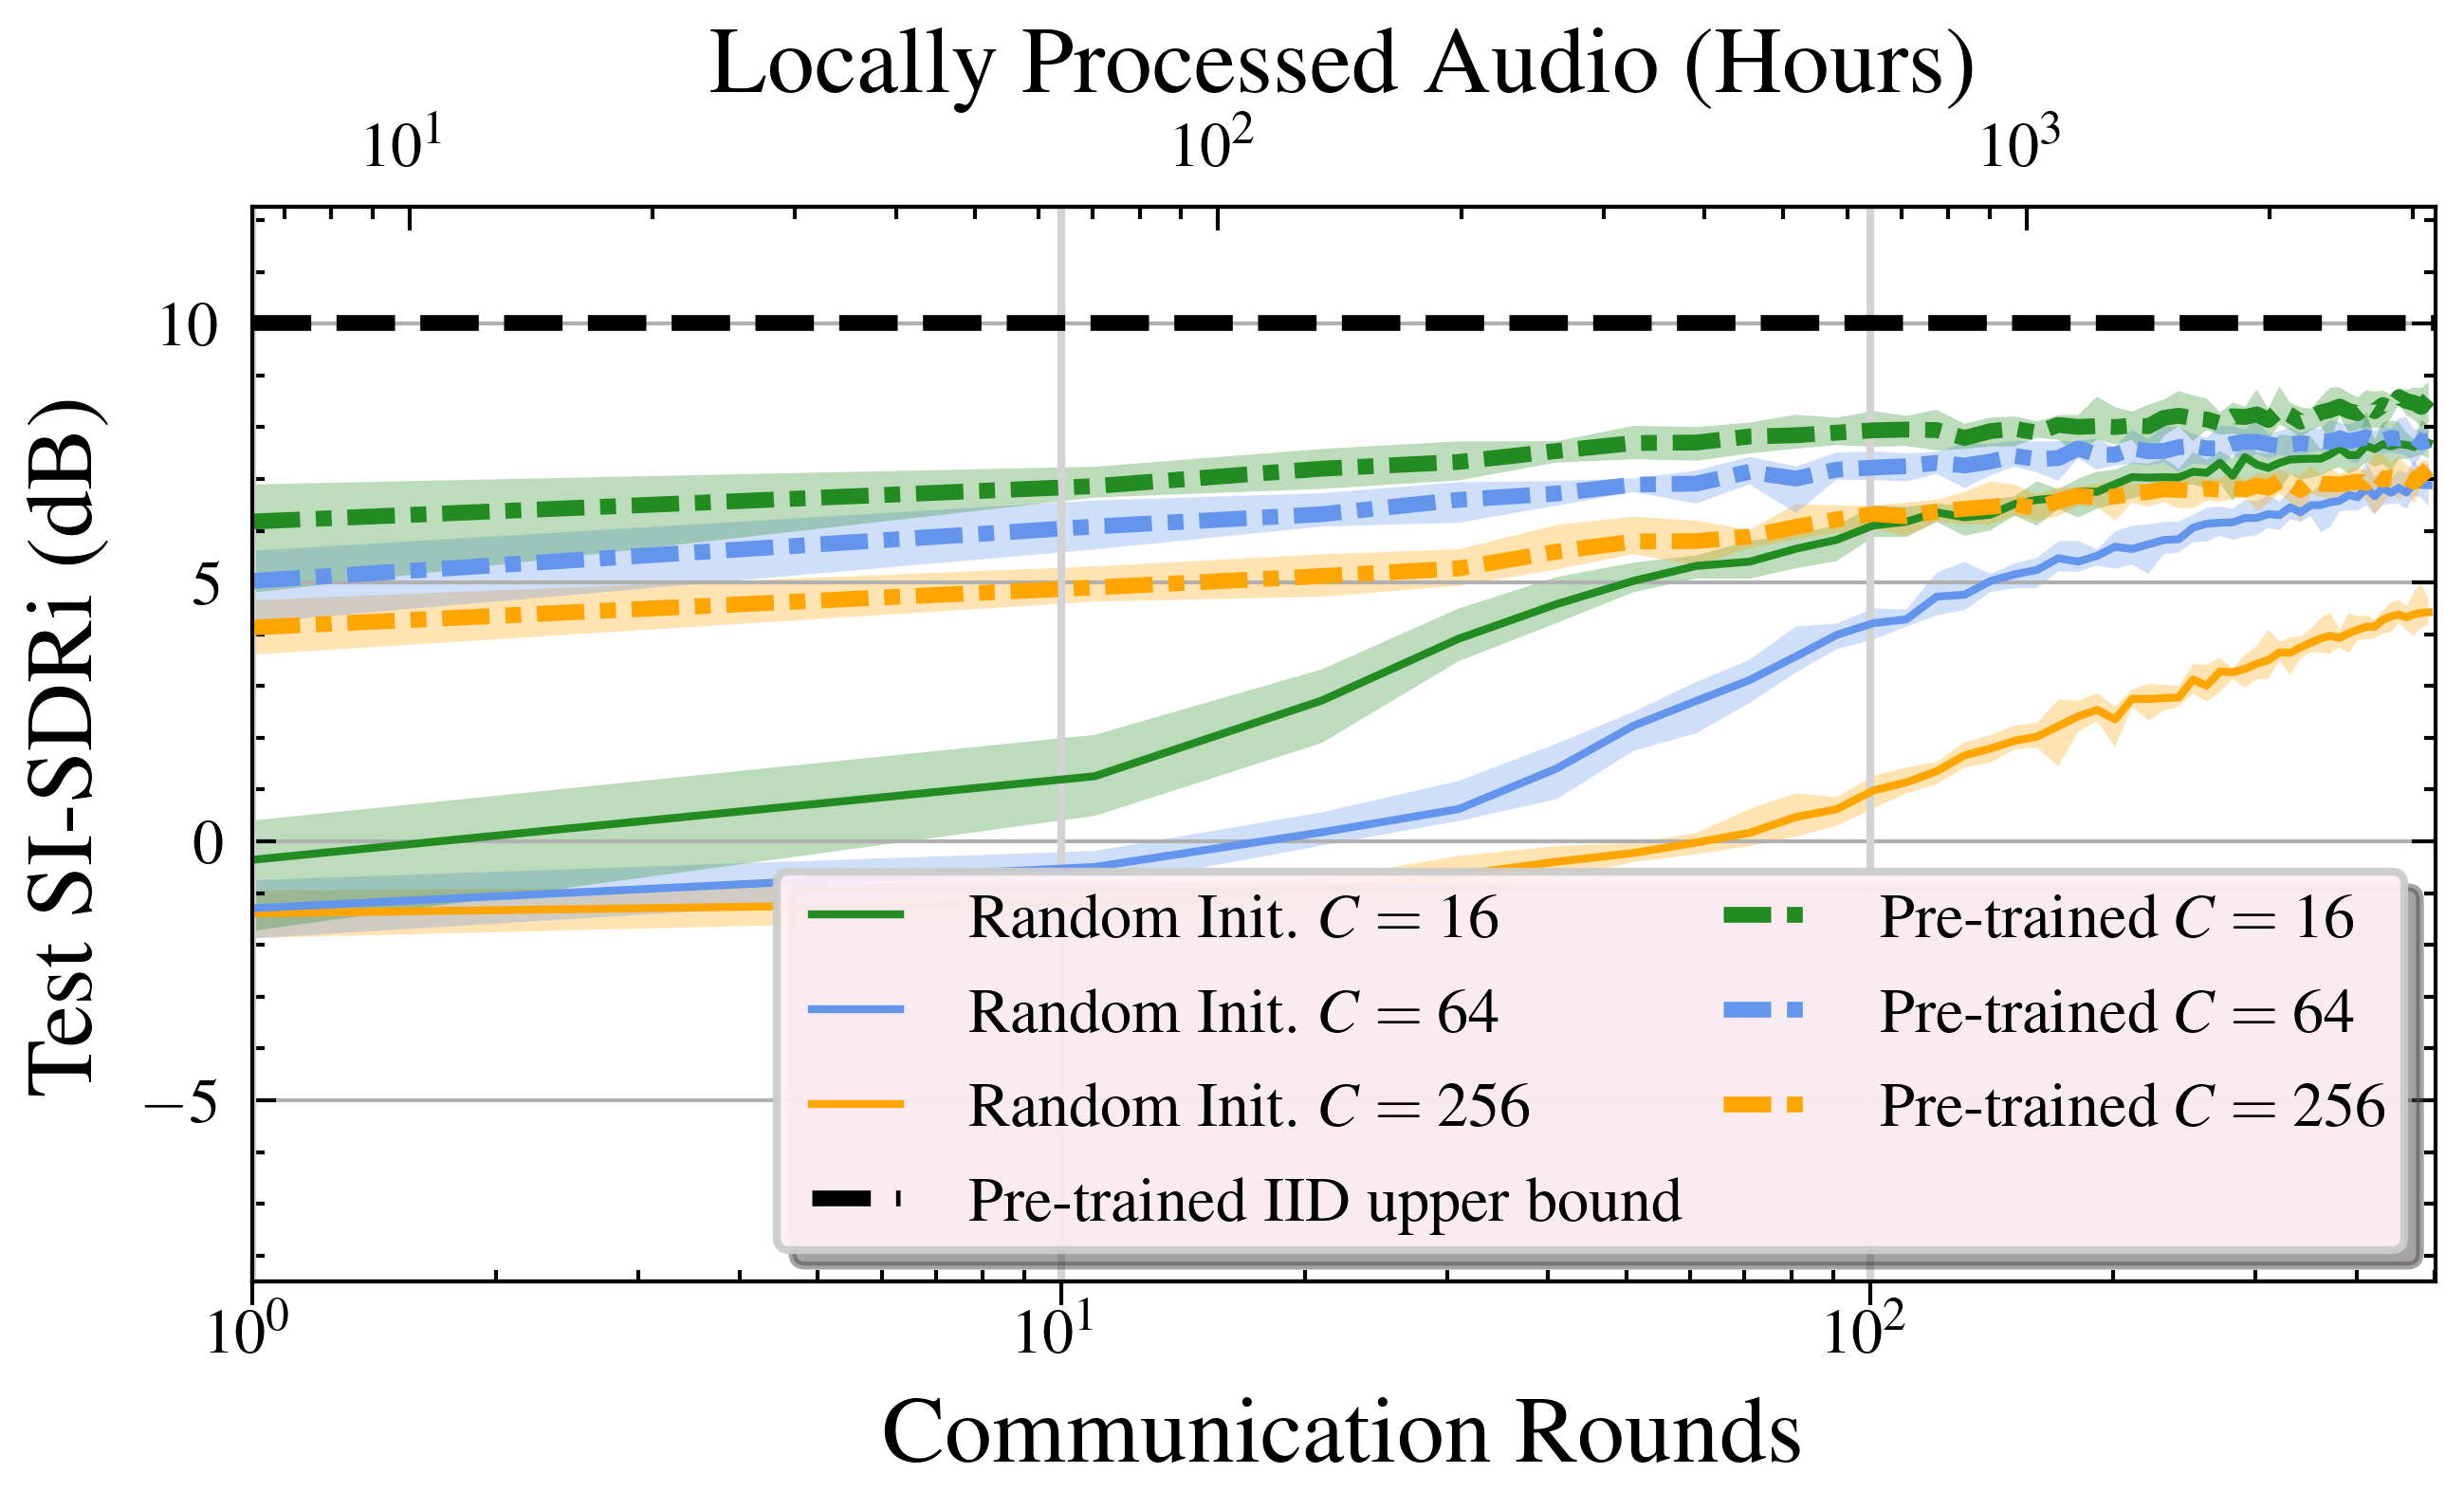

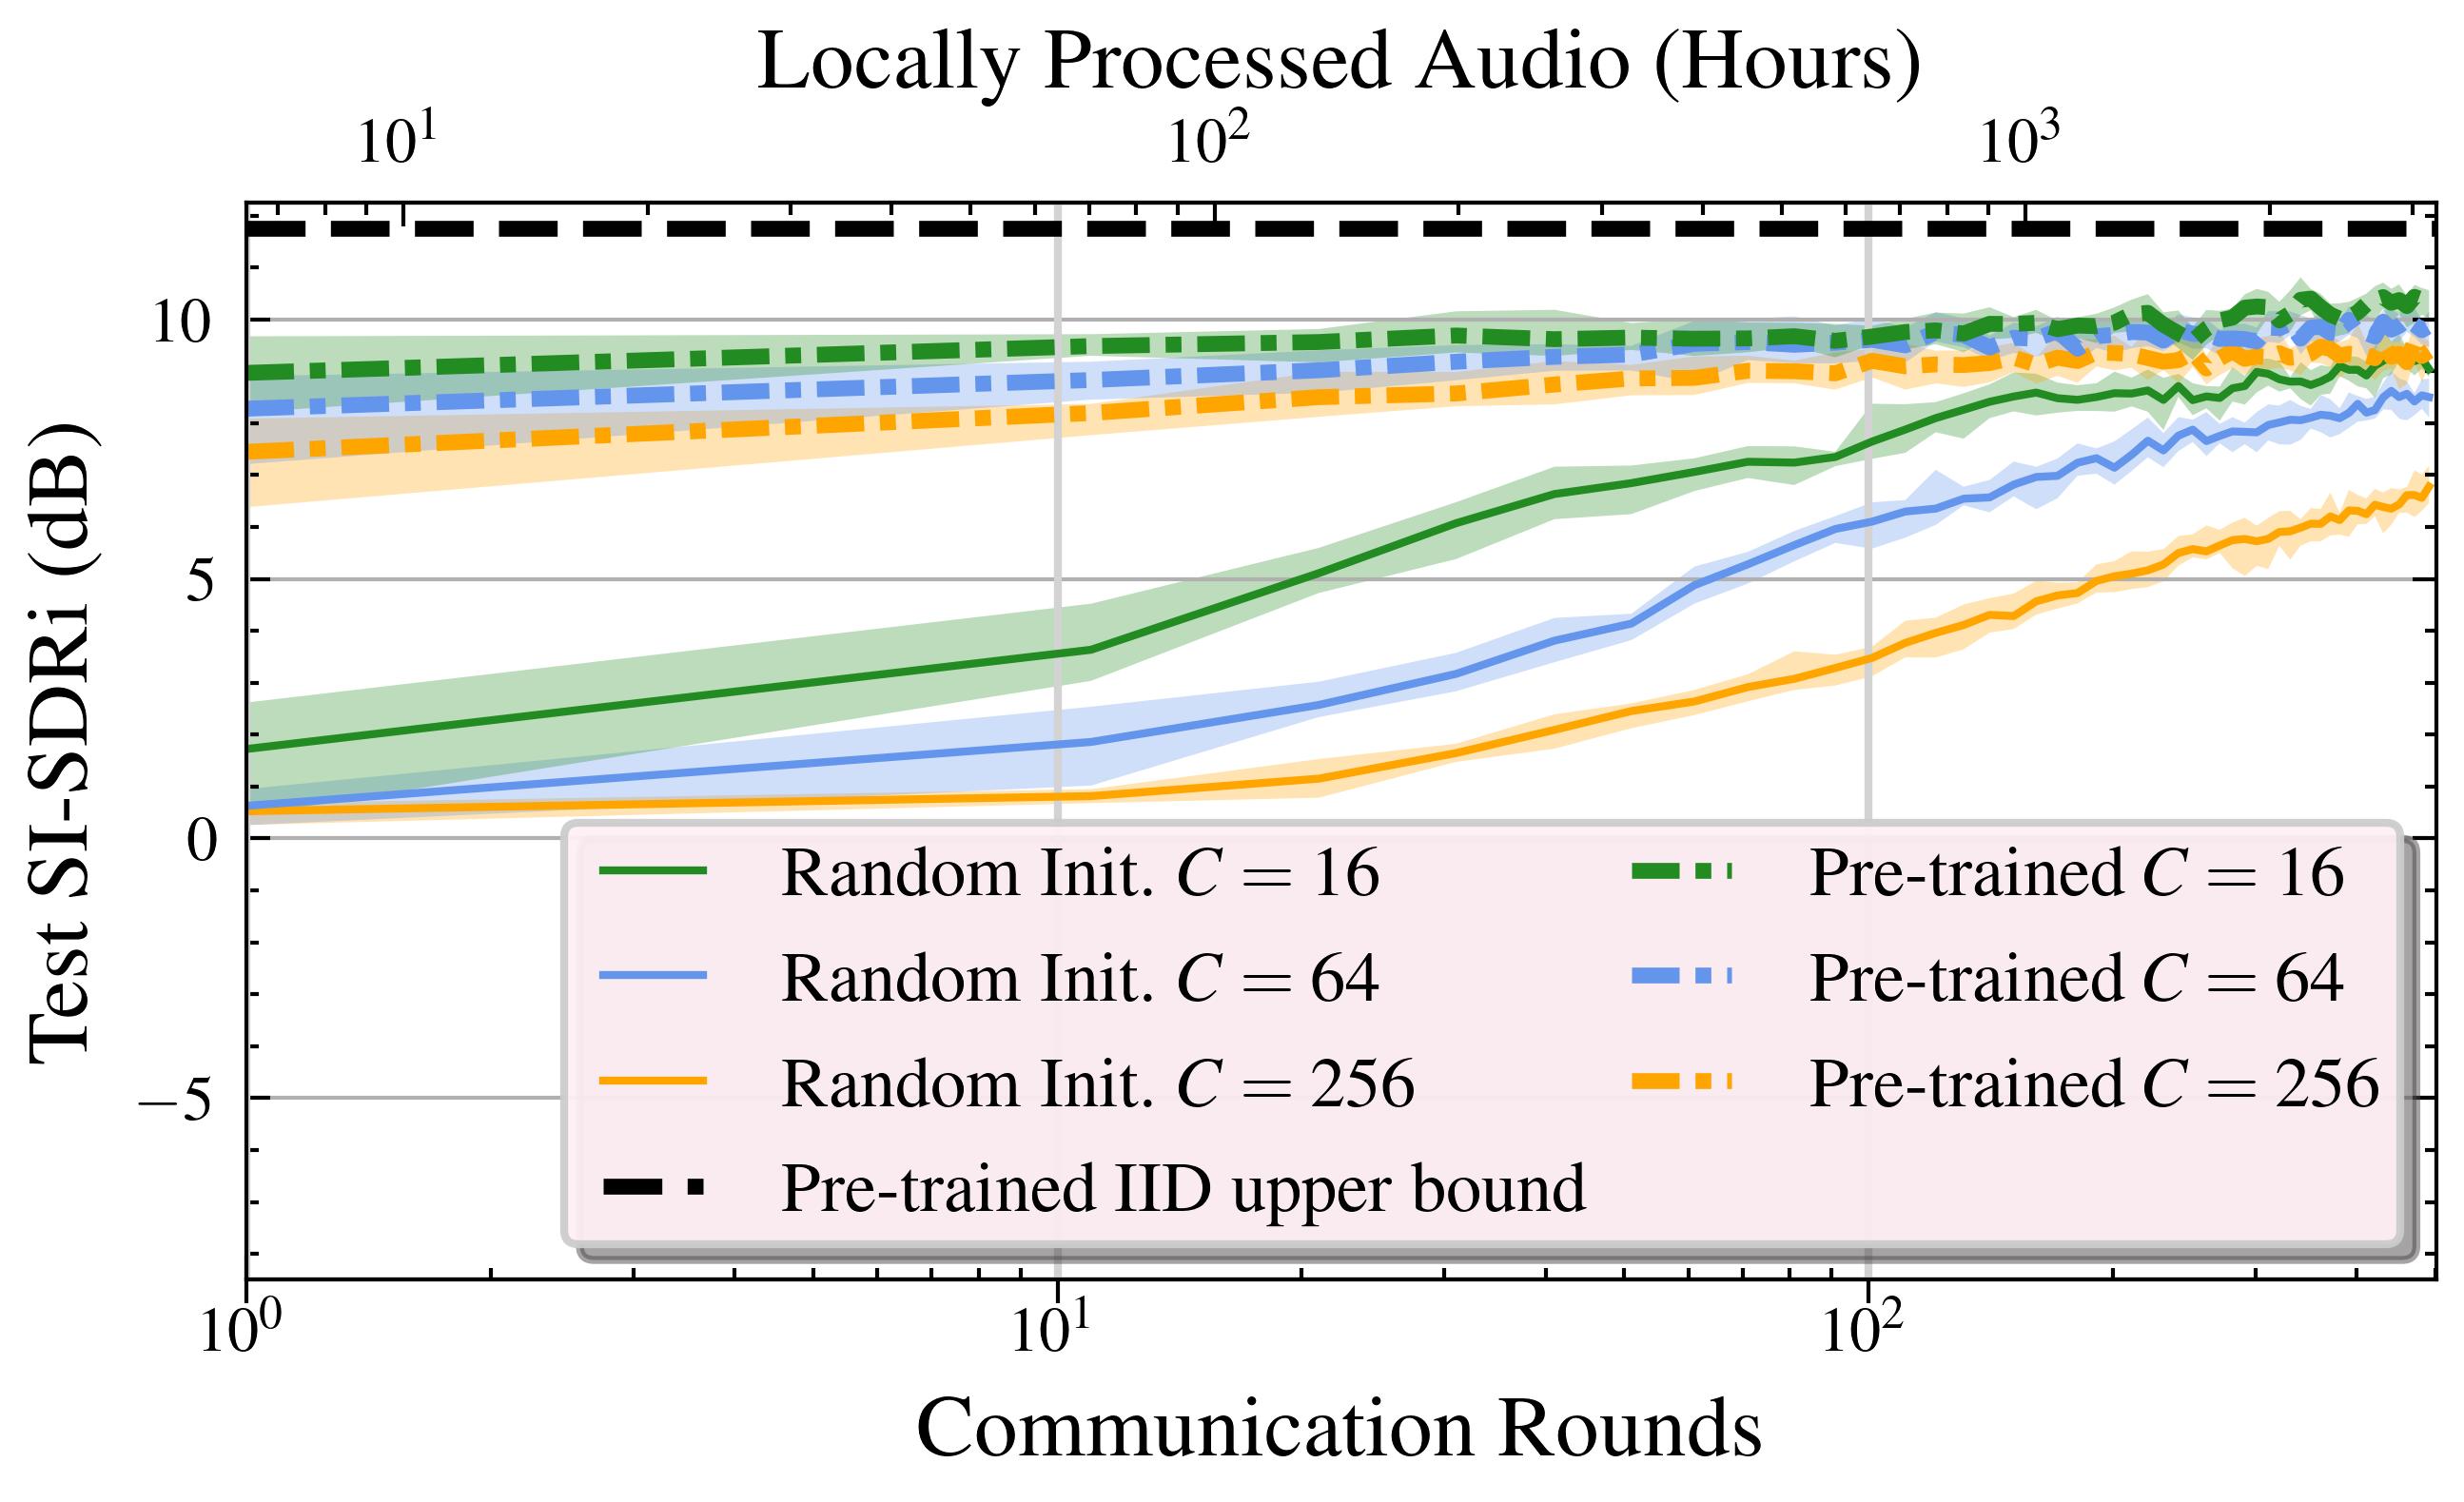

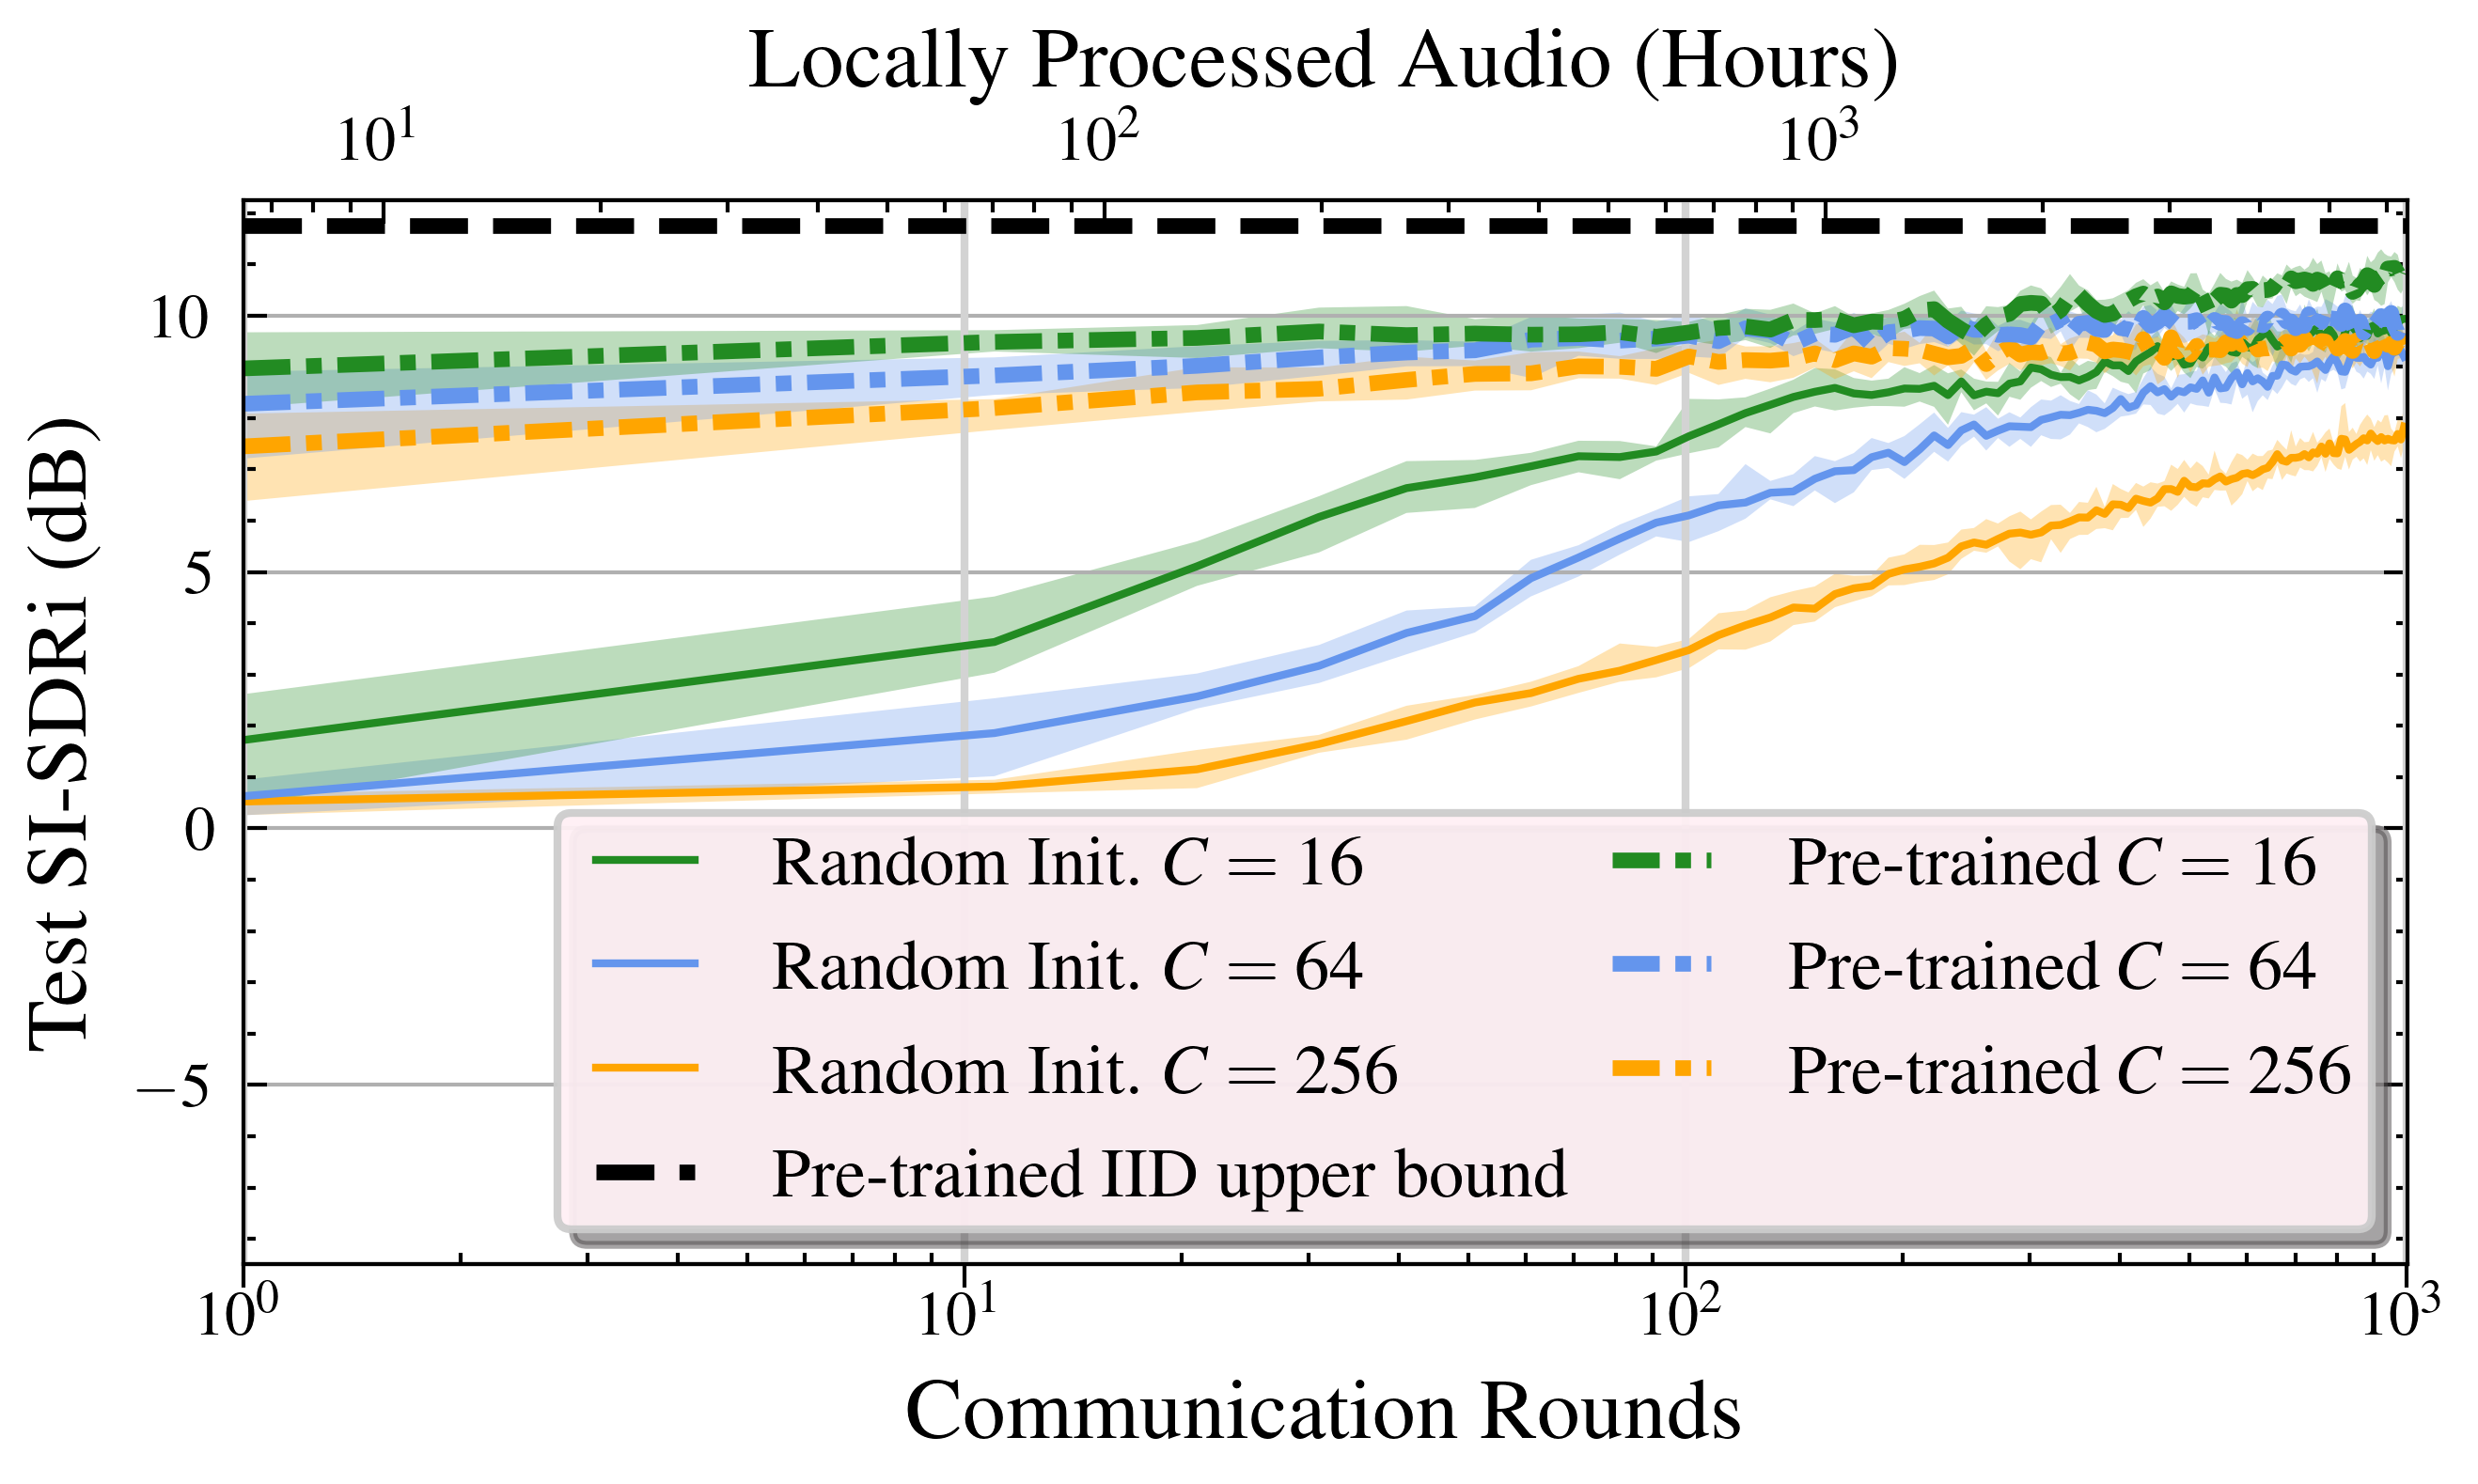

In [8]:
# Make the plot with convergence comparison between from scratch and from the pre-trained model


def get_pretrained_figure_dics_for_num_noise(num_noises):
    metric_name = f'validate_test_SISDRi_enhancement_{num_noises}_noises_mean'
    test_metric_name = metric_name
    val_metric_name = f'validate_SISDRi_enhancement_{num_noises}_noises_mean'
    rename_map = {
        'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': 'Random Init. $C=256$',
        'dnn_multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': 'Random Init. $C=64$',
        'dnn_multi_nodes_16_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0': 'Random Init. $C=16$',
        'pretrained_nodes_256_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0': 'Pre-trained $C=256$',
        'pretrained_nodes_64_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0': 'Pre-trained $C=64$',
        'pretrained_nodes_16_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0': 'Pre-trained $C=16$',
        'pretrained_single_node_unsup_fedunsup': 'Pre-trained IID upper bound'
    }
    
    color_list = ['darkorange', 'royalblue', 'forestgreen',
                  'peachpuff', 'lightskyblue', 'lightgreen',
                  'black']
    
    color_list = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

    color_list = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                  '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'][::-1]

    
    color_list = ['orange', 'cornflowerblue', 'forestgreen',
                  'orange', 'cornflowerblue', 'forestgreen',
                  'black']
    
    figure_dic = {
        'Random Init. $C=256$': {'color': color_list[0], 'linestyle': '-', 'marker': 'o'},
        'Random Init. $C=64$': {'color': color_list[1], 'linestyle': '-', 'marker': 'p'},
        'Random Init. $C=16$': {'color': color_list[2], 'linestyle': '-', 'marker': 's'},
        'Pre-trained $C=256$': {'color': color_list[3], 'linestyle': (0, (3, 1, 1, 1)), 'marker': '*'},
        'Pre-trained $C=64$': {'color': color_list[4], 'linestyle': (0, (3, 1, 1, 1)), 'marker': '*'},
        'Pre-trained $C=16$': {'color': color_list[5], 'linestyle': (0, (3, 1, 1, 1)), 'marker': '*'},
        'Pre-trained IID upper bound': {'color': color_list[6], 'linestyle': '--', 'marker': '*'},
    }

    straight_lines_names = [
        'pretrained_single_node_unsup_fedunsup'
    ]
    straight_lines_dic = dict([(rename_map[x], results_dict['fedenhance'][x])
                               for x in straight_lines_names])

    converging_lines_names = [
        'multi_nodes_256_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0',
        'dnn_multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0',
        'dnn_multi_nodes_16_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0',
        'pretrained_nodes_256_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0',
        'pretrained_nodes_64_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0',
        'pretrained_nodes_16_p_avail_0.25_lre-4_lcl_ep_1_p_sup_0_pat_0'
    ]
    converging_lines_dic = dict([(rename_map[x], results_dict['fedenhance'][x])
                                 for x in converging_lines_names])
    return converging_lines_dic, straight_lines_dic, figure_dic, test_metric_name, val_metric_name


def plot_pretrained_convergence(straight_lines_dic, converging_lines_dic,
                     test_metric_name, val_metric_name, figure_dic, filename,
                     ylabel = 'Test SI-SDRi (dB)', xlabel_down='Communication Rounds',
                     xlabel_top = 'Locally Processed Audio (Hours)',
                     max_epochs=500, axis_fontsize=13, legend_fontsize=8, use_legend=False):
#     fig = plt.gcf()
    fig, ax = plt.subplots(constrained_layout=True)
#     fig.set_size_inches(18.25, 7)
    xs = np.arange(1, max_epochs+1)
    ax.set_xscale('log')
#     ax.tick_params(top='off')
    for j in [1, 10, 100, 1000]:
        ax.axvline(j, linestyle='-', linewidth=1, color='lightgray') # vertical lines
    
    for name, data in converging_lines_dic.items():
        # Smooth out the convergence bars
        ys = data[test_metric_name][:max_epochs]
        print(name, ys.shape)
        smooth_window = 10
        new_xs = np.arange(1, max_epochs+1, smooth_window)
        new_ys = np.reshape(ys, [-1, smooth_window]).mean(-1)
        max_ys = np.reshape(ys, [-1, smooth_window]).max(-1)
        min_ys = np.reshape(ys, [-1, smooth_window]).min(-1)
        linewidth = 1
        if 'trained' in name:
            linewidth = 2
        ax.plot(new_xs, new_ys,
                 color=figure_dic[name]['color'],
                 linestyle=figure_dic[name]['linestyle'],
#                  marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 label=name,
                 linewidth=linewidth,
                 markersize=1)
        ax.fill_between(new_xs, max_ys, min_ys,
                        facecolor=figure_dic[name]['color'], alpha=0.3)

    
    for name, data in straight_lines_dic.items():
        val_ys = data[val_metric_name]
        best_index = np.argmax(val_ys)
        test_ys = data[test_metric_name]
        best_test_value = test_ys[best_index]
        # Repeat the best value across x         
        ys = np.repeat(best_test_value, max_epochs)
        ax.plot(xs, ys,
                 color=figure_dic[name]['color'],
                 linestyle=figure_dic[name]['linestyle'],
#                  marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 label=name,
                 linewidth=2,
                 markersize=1)
        
#     ax.set_xscale('log')
    ax.set_ylabel(ylabel, fontsize=axis_fontsize)
    ax.set_xticks([])
#     ax.set_xlabel(xlabel_down, fontsize=axis_fontsize)
    
    # Add secondary axis with audio processed per communication round
    def hours2rounds(h):
        clips_secs = 4
        total_training_mixtures = 0.5 * 46085 * clips_secs / 3600. 
        return 4 * h / total_training_mixtures
    
    def rounds2hours(x):
        clips_secs = 4
        total_training_mixtures = 0.5 * 46085 * clips_secs / 3600.
        return 0.25 * x * total_training_mixtures
    secax = ax.secondary_xaxis('top', functions=(rounds2hours, hours2rounds))
    secax.set_xlabel(xlabel_top, fontsize=axis_fontsize)
    thiax = ax.secondary_xaxis('bottom', functions=(lambda x: x, lambda x: x))
    thiax.set_xlabel(xlabel_down, fontsize=axis_fontsize)
    secax.set_xscale('log')
    thiax.set_xscale('log')
    thiax.tick_params(top='off')

    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.5, box.height])
    
    def reorder_legend(handles, labels):
        handle_dic = dict([(l, h) for (h, l) in zip(handles, labels)])
        return_list = [
            ('Random Init. $C=16$', handle_dic['Random Init. $C=16$']),
            ('Random Init. $C=64$', handle_dic['Random Init. $C=64$']),            
            ('Random Init. $C=256$', handle_dic['Random Init. $C=256$']),
            ('Pre-trained IID upper bound', handle_dic['Pre-trained IID upper bound']),
            ('Pre-trained $C=16$', handle_dic['Pre-trained $C=16$']),
            ('Pre-trained $C=64$', handle_dic['Pre-trained $C=64$']),
            ('Pre-trained $C=256$', handle_dic['Pre-trained $C=256$']),
        ]
        return [x[0] for x in return_list], [x[1] for x in return_list]

    plt.ylim([-8.5, 12.25])
    plt.xlim([1, max_epochs+1])
#     plt.xticks(np.arange(1, max_epochs+1, 50))
    if use_legend:
        handles, labels = ax.get_legend_handles_labels()
        labels, handles = reorder_legend(handles, labels)

    #     ax.set_xticklabels(xlabels, Fontsize= )
#         plt.legend(handles, labels, borderpad=0.25, columnspacing=0.3,
#                    ncol=3, loc='lower center', fontsize=legend_fontsize, numpoints=2,
#                    fancybox=True, shadow=True, framealpha= 0.94, frameon=True, facecolor='lavenderblush',
#                    bbox_to_anchor=(0.45, -0.5)
#                   )
        plt.legend(handles, labels, borderpad=0.25, columnspacing=0.3,
                   ncol=2, loc='lower right', fontsize=legend_fontsize, numpoints=2,
                   fancybox=True, shadow=True, framealpha= 0.94, frameon=True, facecolor='lavenderblush',
#                    bbox_to_anchor=(0.45, -0.5)
                  )
#     plt.show()
    plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
    plt.grid()
    plt.savefig(f'{filename}.pdf', dpi=100, bbox_inches='tight')

num_noises = 1
filename = f'convergence_pretrained_{num_noises}'
(converging_lines_dic, straight_lines_dic,
 figure_dic, test_metric_name, val_metric_name) = get_pretrained_figure_dics_for_num_noise(num_noises)
plot_pretrained_convergence(straight_lines_dic, converging_lines_dic,
                 test_metric_name, val_metric_name, figure_dic, filename, max_epochs=500,
                 axis_fontsize=12, legend_fontsize=8, use_legend=True)

for max_epochs in [500, 1000]:
    num_noises = 2
    filename = f'convergence_pretrained_{num_noises}_{max_epochs}'

    (converging_lines_dic, straight_lines_dic,
     figure_dic, test_metric_name, val_metric_name) = get_pretrained_figure_dics_for_num_noise(num_noises)
    plot_pretrained_convergence(straight_lines_dic, converging_lines_dic,
                     test_metric_name, val_metric_name, figure_dic, filename, max_epochs=max_epochs,
                     axis_fontsize=11, legend_fontsize=9, use_legend=True)

Val. 1 noise [9.1, 10.1, 10.8, 11.1, 11.5]
Test 1 noise [8.0, 8.3, 8.9, 9.1, 9.3]
Val. 2 noises [10.4, 11.3, 12.0, 12.4, 12.8]
Test 2 noises [9.4, 10.1, 10.5, 11.0, 10.9]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


<Figure size 1980x1500 with 0 Axes>

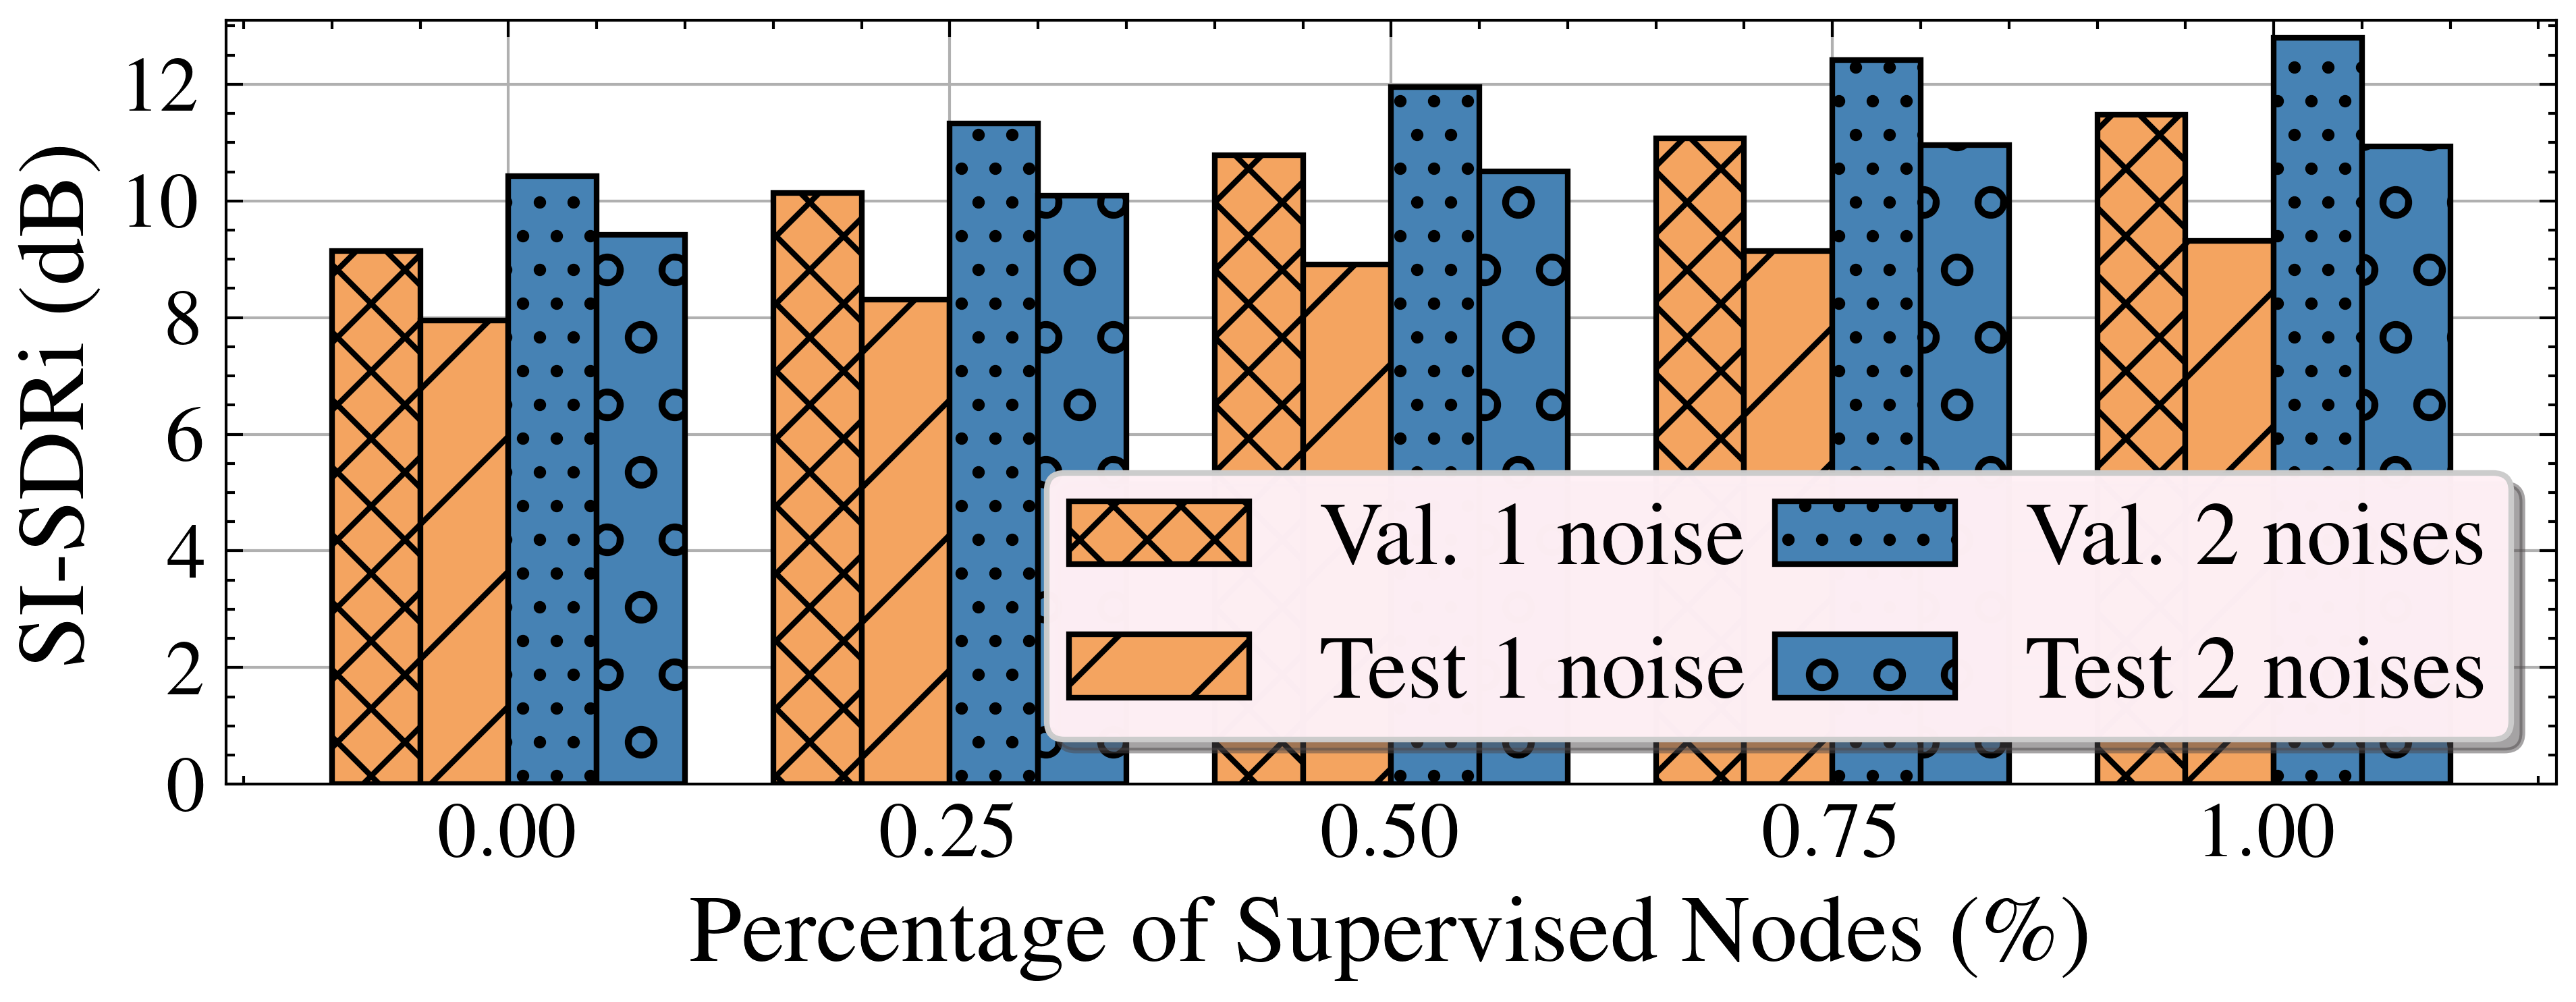

In [9]:
# MAke the barplots with the percentage of supervised nodes
def get_psup_figure_dics_for_num_noise():
    
#     color_list = ['darkorange', 'royalblue', 'forestgreen',
#                   'peachpuff', 'lightskyblue', 'lightgreen',
#                   'black']
    
#     color_list = ['#377eb8', '#ff7f00', '#4daf4a',
#                   '#f781bf', '#a65628', '#984ea3',
#                   '#999999', '#e41a1c', '#dede00']

#     color_list = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
#                   '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'][::-1]

    
    color_list = ['sandybrown', 'sandybrown', 'steelblue', 'steelblue',
                  'orange', 'cornflowerblue', 'forestgreen',
                  'black']
    hatches = ['xx', '/', '..', 'o', '|', '-', 'o', '+', 'x', 'o', 'O', '.', '*']
    
    figure_dic = {
        'validate_SISDRi_enhancement_1_noises_mean': {
            'color': color_list[0], 'hatch': hatches[0]},
        'validate_test_SISDRi_enhancement_1_noises_mean': {
            'color': color_list[1], 'hatch': hatches[1]},
        'validate_SISDRi_enhancement_2_noises_mean': {
            'color': color_list[2], 'hatch': hatches[2]},
        'validate_test_SISDRi_enhancement_2_noises_mean': {
            'color': color_list[3], 'hatch': hatches[3]},
    }

    bars_dic = {
        0.: results_dict['fedenhance']['dnn_multi_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0_pat_0'],
        0.25: results_dict['fedenhance']['psupswe_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0.25_pat_0'],
        0.5: results_dict['fedenhance']['psupswe_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0.5_pat_0'],
        0.75: results_dict['fedenhance']['psupswe_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_0.75_pat_0'],
        1.: results_dict['fedenhance']['psupswe_nodes_64_p_avail_0.25_lcl_ep_1_p_sup_1_pat_0'],
    }
    return bars_dic, figure_dic


def plot_psup(bars_dic, figure_dic, filename,
              ylabel = 'SI-SDRi (dB)', xlabel_down='Percentage of Supervised Nodes (\%)',
              min_epochs=400, max_epochs=500, axis_fontsize=13, ticks_fontsize=15, legend_fontsize=8):
    rename_metric_map = [
        ('validate_SISDRi_enhancement_1_noises_mean', 'Val. 1 noise'),
        ('validate_test_SISDRi_enhancement_1_noises_mean', 'Test 1 noise'),
        ('validate_SISDRi_enhancement_2_noises_mean', 'Val. 2 noises'),
        ('validate_test_SISDRi_enhancement_2_noises_mean', 'Test 2 noises'),
    ]
    
    fig = plt.gcf()
    fig, ax = plt.subplots(constrained_layout=True)
    plt.grid()

#     fig.set_size_inches(9.25, 7)
    xs = np.arange(0., 1.1, 0.25)
    xs_list = xs.tolist()
    width = 0.05
    
    for i, (metric_name, label_metric_name) in enumerate(rename_metric_map):
        this_bar_data = []
        for percentage in xs_list:
            # If it's validation just get the best
            if 'Val.' in label_metric_name:
                val_ys = bars_dic[percentage][metric_name][min_epochs:max_epochs]
                this_bar_data.append(np.max(val_ys))
            else:
                if '1 noise' in label_metric_name:
                    val_ys = bars_dic[percentage]['validate_SISDRi_enhancement_1_noises_mean'][
                        min_epochs:max_epochs]
                    best_idx = np.argmax(val_ys)
                else:
                    val_ys = bars_dic[percentage]['validate_SISDRi_enhancement_2_noises_mean'][
                        min_epochs:max_epochs]
                    best_idx = np.argmax(val_ys)
                this_bar_data.append(bars_dic[percentage][metric_name][min_epochs:max_epochs][best_idx])
#                 this_bar_data.append(np.max(bars_dic[percentage][metric_name]))
            
        print(label_metric_name, list(map(lambda x: round(x, 1), this_bar_data)))
        plt.bar([x + i*width - 2*width for x in xs_list], this_bar_data, color=figure_dic[metric_name]['color'],
               width=width, label=label_metric_name, align="edge",
               edgecolor='black', hatch=figure_dic[metric_name]['hatch'])
#             best_index = np.argmax(val_ys)
#             test_ys = data[test_metric_name]
#             best_test_value = test_ys[best_index]
#             # Repeat the best value across x         
#             ys = np.repeat(best_test_value, max_epochs)
#             ax.plot(xs, ys,
#                      color=figure_dic[name]['color'],
#                      linestyle=figure_dic[name]['linestyle'],
#     #                  marker=figure_dic[model_name]['marker'],
#         #              markerfacecolor='blue',
#                      label=name,
#                      linewidth=2,
#                      markersize=1)

    ax.set_ylabel(ylabel, fontsize=axis_fontsize)
    ax.set_xlabel(xlabel_down, fontsize=axis_fontsize)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 2.25, box.height])
    
    plt.ylim([0., 13.1])
#     plt.xlim([0, max_epochs+1])
    plt.yticks(fontsize=ticks_fontsize)
    plt.xticks(np.arange(0, 1.1, 0.25), fontsize=ticks_fontsize)
    ax.set_axisbelow(True)
    plt.legend(borderpad=0.25, columnspacing=0.3,
               ncol=2, loc='lower right', fontsize=legend_fontsize, numpoints=1,
               fancybox=True, shadow=True, framealpha= 0.99, frameon=True, facecolor='lavenderblush',
#                    bbox_to_anchor=(1.5, 0.4)
              )
#     plt.show()
    plt.savefig(f'{filename}.pdf', dpi=100, bbox_inches='tight')


filename = 'psupswe_bars'

bars_dic, figure_dic = get_psup_figure_dics_for_num_noise()
plot_psup(bars_dic, figure_dic, filename, min_epochs=950, max_epochs=1000,
          axis_fontsize=17, ticks_fontsize=14, legend_fontsize=16)

In [ ]:
a = np.arange(0, 10)
print(a)
print(np.cumsum(a)[smooth_window-1:])
print(np.cumsum(a)[:-smooth_window])

In [ ]:
smooth_window = 5
reshaped_a = np.reshape(a, [-1, smooth_window])
reshaped_a.mean(-1)
reshaped_a.max(-1)
reshaped_a.min(-1)